# Milestone 3

This notebook combines data exploration (milestone 1) and model building and evalution (milestone 2) into 1 notebook. In summary, the following are the changes since the last submission.

1. Treated invalid CLAGE values as missing values
2. Used KNNImputer to impute missing values
3. Treated missing values before treating outliers
4. Tried undersampling to tune XGBoost to increase overall model score. This was not good enough.
5. Tried scale_pos_weight to tune XGBoost to increase overall model score. This is a success.
6. Used SHAP to explain the best model

## Problem Definition

**The context:** Why is this problem important to solve?<br>
**The objectives:** What is the intended goal?<br>
**The key questions:** What are the key questions that need to be answered?<br>
**The problem formulation:** What is it that we are trying to solve using data science?

## Data Description
The Home Equity dataset (HMEQ) contains baseline and loan performance information for 5,960 recent home equity loans. The target (BAD) is a binary variable that indicates whether an applicant has ultimately defaulted or has been severely delinquent. This adverse outcome occurred in 1,189 cases (20 percent). 12 input variables were registered for each applicant.


* **BAD:** 1 = Client defaulted on loan, 0 = loan repaid

* **LOAN:** Amount of loan approved.

* **MORTDUE:** Amount due on the existing mortgage.

* **VALUE:** Current value of the property. 

* **REASON:** Reason for the loan request. (HomeImp = home improvement, DebtCon= debt consolidation which means taking out a new loan to pay off other liabilities and consumer debts) 

* **JOB:** The type of job that loan applicant has such as manager, self, etc.

* **YOJ:** Years at present job.

* **DEROG:** Number of major derogatory reports (which indicates a serious delinquency or late payments). 

* **DELINQ:** Number of delinquent credit lines (a line of credit becomes delinquent when a borrower does not make the minimum required payments 30 to 60 days past the day on which the payments were due). 

* **CLAGE:** Age of the oldest credit line in months. 

* **NINQ:** Number of recent credit inquiries. 

* **CLNO:** Number of existing credit lines.

* **DEBTINC:** Debt-to-income ratio (all your monthly debt payments divided by your gross monthly income. This number is one way lenders measure your ability to manage the monthly payments to repay the money you plan to borrow.

## Important Notes

- This notebook can be considered a guide to refer to while solving the problem. The evaluation will be as per the Rubric shared for each Milestone. Unlike previous courses, it does not follow the pattern of the graded questions in different sections. This notebook would give you a direction on what steps need to be taken in order to get a viable solution to the problem. Please note that this is just one way of doing this. There can be other 'creative' ways to solve the problem and we urge you to feel free and explore them as an 'optional' exercise. 

- In the notebook, there are markdowns cells called - Observations and Insights. It is a good practice to provide observations and extract insights from the outputs.

- The naming convention for different variables can vary. Please consider the code provided in this notebook as a sample code.

- All the outputs in the notebook are just for reference and can be different if you follow a different approach.

- There are sections called **Think About It** in the notebook that will help you get a better understanding of the reasoning behind a particular technique/step. Interested learners can take alternative approaches if they want to explore different techniques. 

# Exploratory Data Analysis

## Explore the data

### Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.impute import KNNImputer #Added for submission 2

from sklearn.linear_model import LogisticRegression

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# for statistical analysis 
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import warnings
warnings.filterwarnings('ignore')

#force 2 decimal values on float
pd.options.display.float_format = '{:.2f}'.format

### Read and describe the dataset

In [2]:
# Understand the content of the original data set
hm=pd.read_csv("hmeq.csv")

In [3]:
hm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [4]:
for i in ['BAD','REASON','JOB']:
    print('Unique values in',i, 'are :')
    print(hm[i].value_counts(dropna=False,normalize=True,ascending=True).sort_index(ascending=True))
    print('*'*40)

Unique values in BAD are :
0   0.80
1   0.20
Name: BAD, dtype: float64
****************************************
Unique values in REASON are :
DebtCon   0.66
HomeImp   0.30
NaN       0.04
Name: REASON, dtype: float64
****************************************
Unique values in JOB are :
Mgr       0.13
Office    0.16
Other     0.40
ProfExe   0.21
Sales     0.02
Self      0.03
NaN       0.05
Name: JOB, dtype: float64
****************************************


In [5]:
hm.size

77480

In [6]:
# Number of records with missing values 
len(hm)-len(hm.dropna())

2596

In [7]:
# of missing values
sum(hm.isnull().values.ravel())

5271

In [8]:
# Copying data to another variable to avoid any changes to original data
data=hm.copy()

In [9]:
# Display first five rows
data.head()

BAD  LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  CLAGE  \
0    1  1100 25860.00  39025.00  HomeImp   Other 10.50   0.00    0.00  94.37   
1    1  1300 70053.00  68400.00  HomeImp   Other  7.00   0.00    2.00 121.83   
2    1  1500 13500.00  16700.00  HomeImp   Other  4.00   0.00    0.00 149.47   
3    1  1500      NaN       NaN      NaN     NaN   NaN    NaN     NaN    NaN   
4    0  1700 97800.00 112000.00  HomeImp  Office  3.00   0.00    0.00  93.33   

   NINQ  CLNO  DEBTINC  
0  1.00  9.00      NaN  
1  0.00 14.00      NaN  
2  1.00 10.00      NaN  
3   NaN   NaN      NaN  
4  0.00 14.00      NaN

In [10]:
# Display last 5 rows
data.tail()

BAD   LOAN  MORTDUE    VALUE   REASON    JOB   YOJ  DEROG  DELINQ  \
5955    0  88900 57264.00 90185.00  DebtCon  Other 16.00   0.00    0.00   
5956    0  89000 54576.00 92937.00  DebtCon  Other 16.00   0.00    0.00   
5957    0  89200 54045.00 92924.00  DebtCon  Other 15.00   0.00    0.00   
5958    0  89800 50370.00 91861.00  DebtCon  Other 14.00   0.00    0.00   
5959    0  89900 48811.00 88934.00  DebtCon  Other 15.00   0.00    0.00   

      CLAGE  NINQ  CLNO  DEBTINC  
5955 221.81  0.00 16.00    36.11  
5956 208.69  0.00 15.00    35.86  
5957 212.28  0.00 15.00    35.56  
5958 213.89  0.00 16.00    34.34  
5959 219.60  0.00 16.00    34.57

In [11]:
# Check the shape of the data

data.shape

(5960, 13)

**Insights ________**
1. There are 5960 records and 13 columns. 
2. There are 10 numeric and 2 categorical input variables.
3. The first 5 rows show debt to income ratio with null values. 4 of these are home improvement loans.
4. The last 5 rows do not have missing values and they are all debt consolidation loans.
5. Row number 3 only has the result (BAD) and loan amount. **Consider removing these types of records as there is only 1 input variable.**

In [12]:
# Check info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


**Insights ______________**
1. There are only 2 categorical input variables - reason and job and they are currently recognized as object data types. 
2. The approved loan amount is an integer.
3. All other (9) numerical input variables are of of type float64.

### Check for missing values

In [13]:
# Analyse missing values - Hint: use isnull() function
data.isnull().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

In [14]:
# Check the percentage of missing values in the each column.
# Hint: divide the result from the previous code by the number of rows in the dataset

df_1=pd.DataFrame(data.isnull().sum() / data.shape[0])*100
print(df_1)

            0
BAD      0.00
LOAN     0.00
MORTDUE  8.69
VALUE    1.88
REASON   4.23
JOB      4.68
YOJ      8.64
DEROG   11.88
DELINQ   9.73
CLAGE    5.17
NINQ     8.56
CLNO     3.72
DEBTINC 21.26


**Insights ________**
1. Debt to Income ratio has the highest percentage of missing values at 21%. Mortgage due, years at the present job, number of major derogatory reports, number of delinquent credit lines, and number of recent credit inquiries have missing values greater than 5%. Since all the columns are mostly filled (not missing), all columns will be kept.
2. It is easier to understand the magnitude of the missing values in terms of percentages. 

### Think about it: 
- We found the total number of missing values and the percentage of missing values, which is better to consider?
- What can be the limit for % missing values in a column in order to avoid it and what are the challenges associated with filling them and avoiding them? 

In [15]:
#4 of The first 5 rows are all HomeImp and all DebtInc=NAN, 
#while the tail are all DebtCon with no missing values
#Compare missing values by Loan Reason
df_2 = pd.DataFrame((data[data['REASON']=='HomeImp'].isnull().sum() /len(data[data['REASON']=='HomeImp']))*100)

In [16]:
df_3 = pd.DataFrame((data[data['REASON']=='DebtCon'].isnull().sum() /len(data[data['REASON']=='DebtCon']))*100)

In [17]:
df_4 = pd.DataFrame((data[data['REASON'].isnull()].isnull().sum() /len(data[data['REASON'].isnull()]))*100)

In [18]:
df_all = pd.concat([df_1,df_2,df_3,df_4],axis=1)

In [19]:
df_all.columns = ['ALL',"Home Imp","DebtCon","NaN"]

In [20]:
print(df_all)

          ALL  Home Imp  DebtCon    NaN
BAD      0.00      0.00     0.00   0.00
LOAN     0.00      0.00     0.00   0.00
MORTDUE  8.69     13.93     4.76  32.94
VALUE    1.88      1.80     1.53   7.94
REASON   4.23      0.00     0.00 100.00
JOB      4.68      3.20     2.93  42.46
YOJ      8.64      8.15     6.77  41.27
DEROG   11.88      9.38    11.38  37.30
DELINQ   9.73      8.43     8.50  38.10
CLAGE    5.17      4.44     3.13  42.06
NINQ     8.56      8.82     6.49  38.89
CLNO     3.72      3.54     1.88  33.73
DEBTINC 21.26     23.09    20.37  22.22


**Insights ________**

* While the first and last 5 rows seem to imply that there is considerable difference in missing values between home improvement and debt consolidation rows, this is not the case.
* However where Reason is null, all the other features have more null values. 
* See if it is good to remove all rows where REASON == NULL

In [21]:
# Review how many records have NULL reasons
data['REASON'].value_counts(dropna=False)

DebtCon    3928
HomeImp    1780
NaN         252
Name: REASON, dtype: int64

In [22]:
data['REASON'].value_counts(dropna=False,normalize=True)

DebtCon   0.66
HomeImp   0.30
NaN       0.04
Name: REASON, dtype: float64

In [23]:
no_reason_df = data[data['REASON'].isnull()].copy()
no_reason_df.shape

(252, 13)

In [24]:
#Check if missing values have impact on the output variable, BAD
missing_col = [col for col in data.columns if data[col].isnull().any()]

for i in missing_col:
    print('Distribution of loan status for ' +i)
    print(data[data[i].isnull()]['BAD'].value_counts(normalize=True))

Distribution of loan status for MORTDUE
0   0.80
1   0.20
Name: BAD, dtype: float64
Distribution of loan status for VALUE
1   0.94
0   0.06
Name: BAD, dtype: float64
Distribution of loan status for REASON
0   0.81
1   0.19
Name: BAD, dtype: float64
Distribution of loan status for JOB
0   0.92
1   0.08
Name: BAD, dtype: float64
Distribution of loan status for YOJ
0   0.87
1   0.13
Name: BAD, dtype: float64
Distribution of loan status for DEROG
0   0.88
1   0.12
Name: BAD, dtype: float64
Distribution of loan status for DELINQ
0   0.88
1   0.12
Name: BAD, dtype: float64
Distribution of loan status for CLAGE
0   0.75
1   0.25
Name: BAD, dtype: float64
Distribution of loan status for NINQ
0   0.85
1   0.15
Name: BAD, dtype: float64
Distribution of loan status for CLNO
0   0.76
1   0.24
Name: BAD, dtype: float64
Distribution of loan status for DEBTINC
1   0.62
0   0.38
Name: BAD, dtype: float64


In [25]:
#Since the data is less than 5% and the proportion of good and bad loans remain, we can drop all rows where REASON = NULL
data.drop(data.loc[data['REASON'].isnull()].index,inplace=True)

In [26]:
data.shape

(5708, 13)

In [27]:
#Review how this affects distribution of categories and of missing values
for i in ['BAD','REASON','JOB']:
    print('Unique values in',i, 'are :')
    print(data[i].value_counts(dropna=False,normalize=True,ascending=True).sort_index(ascending=True))
    print('*'*40)

Unique values in BAD are :
0   0.80
1   0.20
Name: BAD, dtype: float64
****************************************
Unique values in REASON are :
DebtCon   0.69
HomeImp   0.31
Name: REASON, dtype: float64
****************************************
Unique values in JOB are :
Mgr       0.13
Office    0.16
Other     0.41
ProfExe   0.22
Sales     0.02
Self      0.03
NaN       0.03
Name: JOB, dtype: float64
****************************************


In [28]:
(data.isnull().sum() / data.shape[0])*100

BAD        0.00
LOAN       0.00
MORTDUE    7.62
VALUE      1.61
REASON     0.00
JOB        3.01
YOJ        7.20
DEROG     10.76
DELINQ     8.48
CLAGE      3.54
NINQ       7.22
CLNO       2.40
DEBTINC   21.22
dtype: float64

In [29]:
for i in missing_col:
    print('Distribution of loan status for missing values ' +i)
    print(data[data[i].isnull()]['BAD'].value_counts(normalize=True))

Distribution of loan status for missing values MORTDUE
0   0.77
1   0.23
Name: BAD, dtype: float64
Distribution of loan status for missing values VALUE
1   1.00
Name: BAD, dtype: float64
Distribution of loan status for missing values REASON
Series([], Name: BAD, dtype: float64)
Distribution of loan status for missing values JOB
0   0.92
1   0.08
Name: BAD, dtype: float64
Distribution of loan status for missing values YOJ
0   0.85
1   0.15
Name: BAD, dtype: float64
Distribution of loan status for missing values DEROG
0   0.87
1   0.13
Name: BAD, dtype: float64
Distribution of loan status for missing values DELINQ
0   0.86
1   0.14
Name: BAD, dtype: float64
Distribution of loan status for missing values CLAGE
0   0.64
1   0.36
Name: BAD, dtype: float64
Distribution of loan status for missing values NINQ
0   0.83
1   0.17
Name: BAD, dtype: float64
Distribution of loan status for missing values CLNO
0   0.65
1   0.35
Name: BAD, dtype: float64
Distribution of loan status for missing values 

In [30]:
sum(data.isnull().values.ravel())

4170

In [31]:
data.size

74204

In [32]:
len(data)-len(data.dropna())

2344

###Insights ________###

1. 44% of the records in the original data set have missing values. Removing these rows will reduce the data set significantly. Thus, it is not recommended to disregard all rows with missing values.
2. When looking at the first and last 5 rows, it looked like that there is a difference in missing values between Home Improvement loans vs Debt Consolidation loans.
3. Looking at this closer revealed that the records with unknown or null reasons have significantly more null values compared to home improvement and debt consolidation records. 
4. After reviewing that the distribution of the output variable BAD will not change and that the number of loans with no reasons is less than 5%, these loan records were removed.
5. This new data set reduced the missing values but kept the distribution of categorical values largely the same.
6. Reviewing the missing values per feature showed that some of the proportion of the BAD loans is more than that of the data set (20%). 
    - Mortgage 22%
    - Property Value 100%
    - Age of oldest credit line 36%
    - Number of credit lines 35%
    - Debt to income ratio 38%
    
The impact of these missing values should be considered when developing the classification model.

### Convert the data types

**We can convert the object type columns to categories**

`converting "objects" to "category" reduces the data space required to store the dataframe`

In [33]:
cols = data.select_dtypes(['object']).columns.tolist()

#adding target variable to this list as this is an classification problem and the target variable is categorical

cols.append('BAD')

In [34]:
cols

['REASON', 'JOB', 'BAD']

In [35]:
# Changing the data type of object type column to category. hint use astype() function
# remove ___________ and complete the code

for i in cols:
    data[i] = data[i].astype('category')

In [36]:
# Checking the info again and the datatype of different variable
# remove ___________ and complete the code

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5708 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   BAD      5708 non-null   category
 1   LOAN     5708 non-null   int64   
 2   MORTDUE  5273 non-null   float64 
 3   VALUE    5616 non-null   float64 
 4   REASON   5708 non-null   category
 5   JOB      5536 non-null   category
 6   YOJ      5297 non-null   float64 
 7   DEROG    5094 non-null   float64 
 8   DELINQ   5224 non-null   float64 
 9   CLAGE    5506 non-null   float64 
 10  NINQ     5296 non-null   float64 
 11  CLNO     5571 non-null   float64 
 12  DEBTINC  4497 non-null   float64 
dtypes: category(3), float64(9), int64(1)
memory usage: 507.7 KB


### Analyze Summary Statistics of the dataset

In [37]:
# Analyze the summary statistics for numerical variables
# Remove ___________ and complete the code

data.describe().T

count      mean      std     min      25%      50%       75%  \
LOAN    5708.00  18722.32 11327.21 1100.00 11100.00 16400.00  23500.00   
MORTDUE 5273.00  73950.00 44543.60 2063.00 46451.00 65178.00  91491.00   
VALUE   5616.00 102018.00 57798.04 8000.00 66244.75 89571.00 119613.75   
YOJ     5297.00      8.89     7.52    0.00     3.00     7.00     13.00   
DEROG   5094.00      0.25     0.83    0.00     0.00     0.00      0.00   
DELINQ  5224.00      0.44     1.11    0.00     0.00     0.00      0.00   
CLAGE   5506.00    178.95    85.71    0.00   114.85   172.40    229.70   
NINQ    5296.00      1.19     1.73    0.00     0.00     1.00      2.00   
CLNO    5571.00     21.36    10.12    0.00    14.00    20.00     26.00   
DEBTINC 4497.00     34.00     8.25    0.52    29.30    34.98     39.11   

              max  
LOAN     89900.00  
MORTDUE 399550.00  
VALUE   855909.00  
YOJ         41.00  
DEROG       10.00  
DELINQ      15.00  
CLAGE     1168.23  
NINQ        17.00  
CLNO        71.00  
DEBTINC    203.31

**Insights ______________**
1. In all the above features, the max is far from the 75% quartile values (at least 3 times over) indicating that max values are likely outliers.
2. The remaining mortgage and property value vary widely indicating that mortgages may be for different age groups and that properties are of different types or locations. It would be good to see if these 2 values have any correlations.
3. The number of major derogatory reports and the number of delinquent lines are mostly 0s. This is expected since 80% of the loan records did not default, meaning that 80% are most likely good borrowers. 
5. Majority of the loaners are in their present job for 13 years or less.
6. Majority of the loaners have 2 or fewer recent credit inquiries.


### Treat junk or invalid values
7. While some of the maximum values are at the high end, none of them are invalid. E.g., one 
can be overly indebted and can have 200+% debt to income ratio. Perhaps the most suspicious 
is the line of credit with age of 97 years (1168/12). The median is at 14 years and the 75% quartile at 19 yrs. Let's inspect these records.

In [38]:
data.loc[data['CLAGE']>229]

BAD   LOAN   MORTDUE     VALUE   REASON      JOB   YOJ  DEROG  DELINQ  \
15     1   2200  24280.00  34687.00  HomeImp    Other   NaN   0.00    1.00   
28     1   2500  25116.00  36350.00  HomeImp    Other 10.00   1.00    2.00   
30     0   2500  71408.00  78600.00  HomeImp  ProfExe  8.00   0.00    0.00   
37     1   2900  61962.00  70915.00  DebtCon      Mgr  2.00   0.00    0.00   
46     1   3000  47000.00  82700.00  HomeImp  ProfExe 10.00   0.00    1.00   
...   ..    ...       ...       ...      ...      ...   ...    ...     ...   
5897   0  60000 122729.00 207797.00  DebtCon  ProfExe  9.00   0.00    0.00   
5901   0  62500 124491.00 198338.00  DebtCon  ProfExe 10.00   0.00    0.00   
5902   0  62700 120598.00 207803.00  DebtCon  ProfExe  9.00   0.00    0.00   
5903   0  62900 119903.00 201928.00  DebtCon  ProfExe  9.00   0.00    0.00   
5925   0  69700 191972.00 294367.00  DebtCon     Self 10.00   0.00    0.00   

      CLAGE  NINQ  CLNO  DEBTINC  
15   300.87  0.00  8.00      NaN  
28   276.97  0.00  9.00      NaN  
30   255.73  0.00 12.00      NaN  
37   282.80  3.00 37.00    49.21  
46   262.17  5.00 26.00      NaN  
...     ...   ...   ...      ...  
5897 313.33  2.00 27.00    35.03  
5901 324.32  1.00 26.00    38.07  
5902 304.31  2.00 26.00    36.44  
5903 297.31  1.00 25.00    37.64  
5925 230.71  2.00 25.00    28.20  

[1393 rows x 13 columns]

In [39]:
data.loc[data['CLAGE']>600]

BAD   LOAN  MORTDUE     VALUE   REASON      JOB   YOJ  DEROG  DELINQ  \
3097   1  16800 87300.00 155500.00  DebtCon    Other  3.00   0.00    0.00   
3679   1  19300 96454.00 157809.00  DebtCon    Other  3.00   0.00    0.00   
3787   0  20000 56135.00  93234.00  HomeImp  ProfExe 18.00   0.00    0.00   
3856   0  20200 61303.00  97780.00  HomeImp  ProfExe 17.00   0.00    1.00   
3868   0  20200 59347.00  97816.00  HomeImp  ProfExe 18.00   0.00    0.00   
3928   0  20500 64113.00  98322.00  HomeImp  ProfExe 16.00   0.00    0.00   
4040   0  21100 63955.00  95621.00  HomeImp  ProfExe 19.00   0.00    0.00   
4059   0  21200 63093.00 101789.00  HomeImp  ProfExe 18.00   0.00    0.00   
4098   0  21400 64378.00  99343.00  HomeImp  ProfExe 18.00   0.00    0.00   
4143   0  21600 59219.00  98111.00  HomeImp  ProfExe 18.00   0.00    0.00   
4153   0  21700 62506.00  96588.00  HomeImp  ProfExe 18.00   0.00    1.00   
4238   0  22000 61042.00  96622.00  HomeImp  ProfExe 17.00   0.00    0.00   
4262   0  22200 57458.00 102195.00  HomeImp  ProfExe 18.00   0.00    0.00   
4264   0  22200 64809.00  96831.00  HomeImp  ProfExe 17.00   0.00    0.00   
4357   0  22600 61503.00 101786.00  HomeImp  ProfExe 17.00   0.00    0.00   
4390   0  22800 62754.00 101781.00  HomeImp  ProfExe 19.00   0.00    0.00   
4402   0  22900 59702.00  97591.00  HomeImp  ProfExe 16.00   0.00    0.00   
4417   0  23000 58696.00 102176.00  HomeImp  ProfExe 18.00   0.00    0.00   
4470   0  23300 61496.00 102823.00  HomeImp  ProfExe 18.00   0.00    0.00   
4536   0  23700 57553.00 101656.00  HomeImp  ProfExe 19.00   0.00    0.00   

       CLAGE  NINQ  CLNO  DEBTINC  
3097 1154.63  0.00  0.00      NaN  
3679 1168.23  0.00  0.00    40.21  
3787  630.03  1.00 24.00      NaN  
3856  632.10  1.00 24.00    20.74  
3868  618.74  1.00 24.00    21.67  
3928  634.46  1.00 23.00    19.57  
4040  626.30  0.00 24.00    20.01  
4059  623.46  1.00 24.00    19.41  
4098  627.70  1.00 23.00    20.69  
4143  626.77  1.00 23.00    21.24  
4153  615.13  0.00 24.00    21.97  
4238  638.28  1.00 23.00    21.46  
4262  628.16  1.00 24.00    20.50  
4264  639.06  0.00 24.00    22.61  
4357  622.36  1.00 24.00    21.69  
4390  628.98  0.00 24.00    20.20  
4402  627.66  0.00 24.00    22.12  
4417  629.10  0.00 23.00    22.83  
4470  649.75  1.00 24.00    20.87  
4536  648.33  0.00 23.00    22.85

In [40]:
data.loc[data['CLAGE']>700]

BAD   LOAN  MORTDUE     VALUE   REASON    JOB  YOJ  DEROG  DELINQ  \
3097   1  16800 87300.00 155500.00  DebtCon  Other 3.00   0.00    0.00   
3679   1  19300 96454.00 157809.00  DebtCon  Other 3.00   0.00    0.00   

       CLAGE  NINQ  CLNO  DEBTINC  
3097 1154.63  0.00  0.00      NaN  
3679 1168.23  0.00  0.00    40.21

In [41]:
#Other values seems to be under 650. Change these 
#Change the 2 extreme values to Null so they can be treated as missing values later.
data.loc[data['CLAGE'] > 1000,'CLAGE'] = np.nan

In [42]:
data.describe().T

count      mean      std     min      25%      50%       75%  \
LOAN    5708.00  18722.32 11327.21 1100.00 11100.00 16400.00  23500.00   
MORTDUE 5273.00  73950.00 44543.60 2063.00 46451.00 65178.00  91491.00   
VALUE   5616.00 102018.00 57798.04 8000.00 66244.75 89571.00 119613.75   
YOJ     5297.00      8.89     7.52    0.00     3.00     7.00     13.00   
DEROG   5094.00      0.25     0.83    0.00     0.00     0.00      0.00   
DELINQ  5224.00      0.44     1.11    0.00     0.00     0.00      0.00   
CLAGE   5504.00    178.60    83.65    0.00   114.83   172.35    229.52   
NINQ    5296.00      1.19     1.73    0.00     0.00     1.00      2.00   
CLNO    5571.00     21.36    10.12    0.00    14.00    20.00     26.00   
DEBTINC 4497.00     34.00     8.25    0.52    29.30    34.98     39.11   

              max  
LOAN     89900.00  
MORTDUE 399550.00  
VALUE   855909.00  
YOJ         41.00  
DEROG       10.00  
DELINQ      15.00  
CLAGE      649.75  
NINQ        17.00  
CLNO        71.00  
DEBTINC    203.31

In [43]:
# Check summary for categorical data
data.describe(include=['category']).T

count unique      top  freq
BAD     5708      2        0  4567
REASON  5708      2  DebtCon  3928
JOB     5536      6    Other  2320

**Insights _____________**
1. 80% of the loans (4567 of all records have 0 value) in the dataset did not result in default.
2. There are only 2 reasons for the loan - home improvement and debt consolidation.
3. There are 6 categories of job with 40% categorized as Other. An Other classification can mean many things and is not a good descriptor.

**Let's look at the unique values in all the categorical variables**

In [44]:
# Checking the count of unique values in each categorical column 
cols_cat= data.select_dtypes(['category'])

for i in cols_cat.columns:
    print('Unique values in',i, 'are :')
    print(data[i].value_counts(dropna=False,normalize=True,ascending=True).sort_index(ascending=True))
    print('*'*40)

Unique values in BAD are :
0   0.80
1   0.20
Name: BAD, dtype: float64
****************************************
Unique values in REASON are :
DebtCon   0.69
HomeImp   0.31
Name: REASON, dtype: float64
****************************************
Unique values in JOB are :
Mgr       0.13
Office    0.16
Other     0.41
ProfExe   0.22
Sales     0.02
Self      0.03
NaN       0.03
Name: JOB, dtype: float64
****************************************


**Insights _____________**
1. 66% of the loans in the data set are for debt consolidation.
2. The job categories do not seem descriptive or robust enough. 40% are marked as Others.
3. More than 30% of the loaners are in managerial and executive positions with the minority in sales and self-employment.

### Think about it
- The results above gave the absolute count of unique values in each categorical column. Are absolute values a good measure? 
- If not, what else can be used? Try implementing that. 

## Univariate Analysis

Univariate analysis is used to explore each variable in a data set, separately. It looks at the range of values, as well as the central tendency of the values. It can be done for both numerical and categorical variables

### Univariate Analysis - Numerical Data
Histograms and box plots help to visualize and describe numerical data. We use box plot and histogram to analyze the numerical columns.

In [45]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical variable.
# This function takes the numerical column as the input and return the boxplots and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins,palette="winter") if bins else sns.distplot(feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    #print(np.mean(feature))
    #print(np.median(feature))
    ax_hist2.axvline(np.nanmedian(feature), color='black', linestyle='-') # Add median to the histogram


#### Using the above function, let's first analyze the Histogram and Boxplot for LOAN and other continuous variables

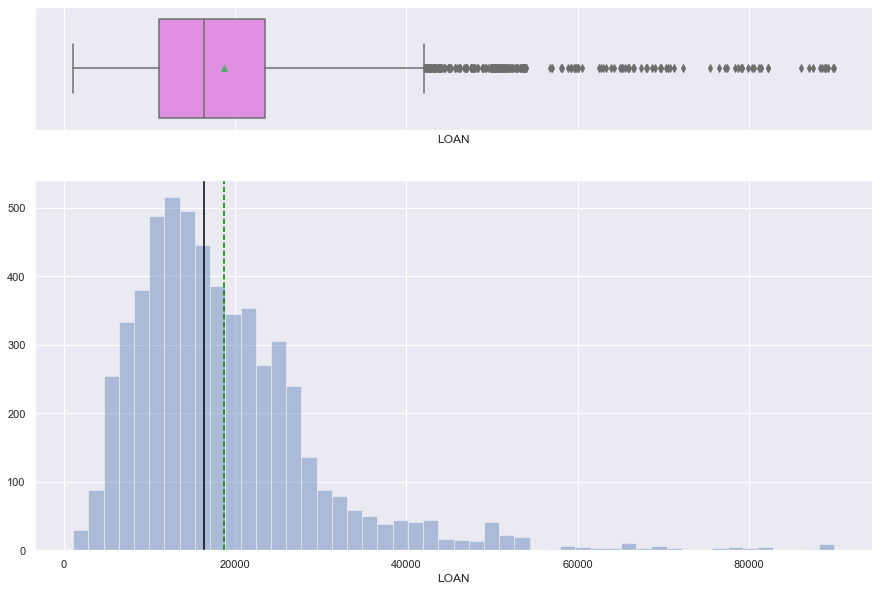

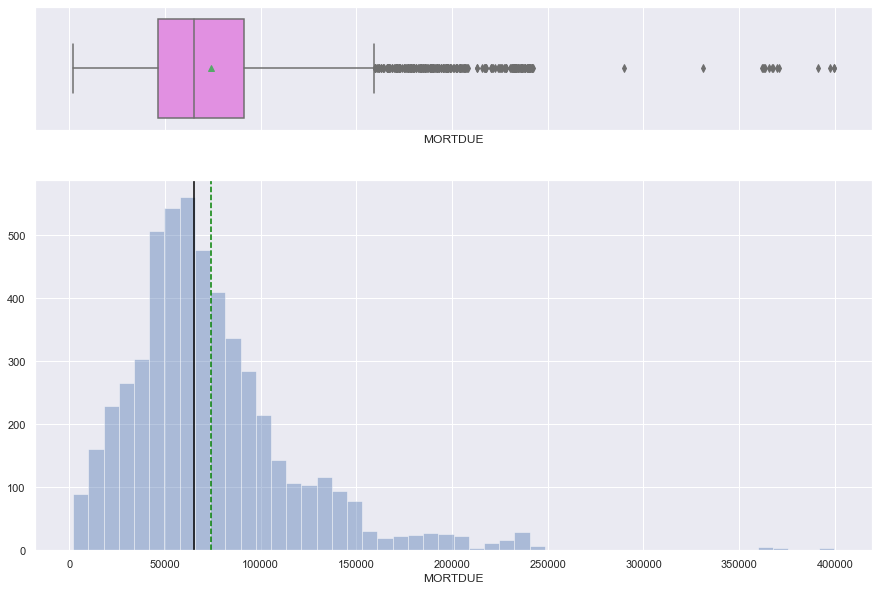

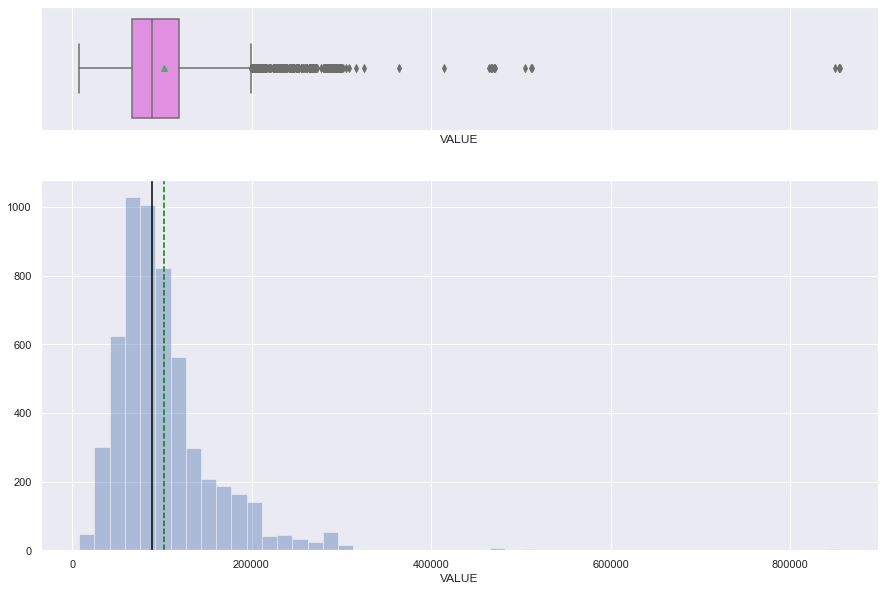

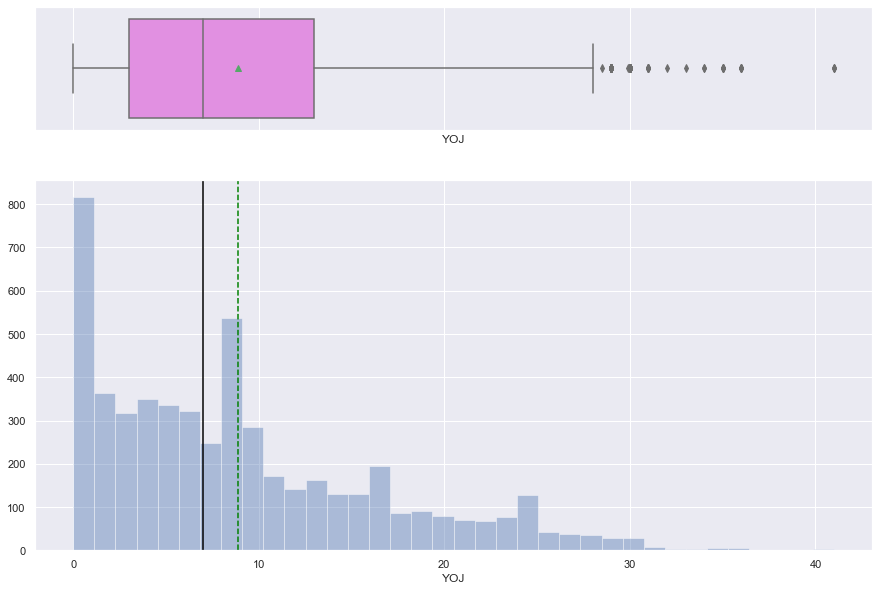

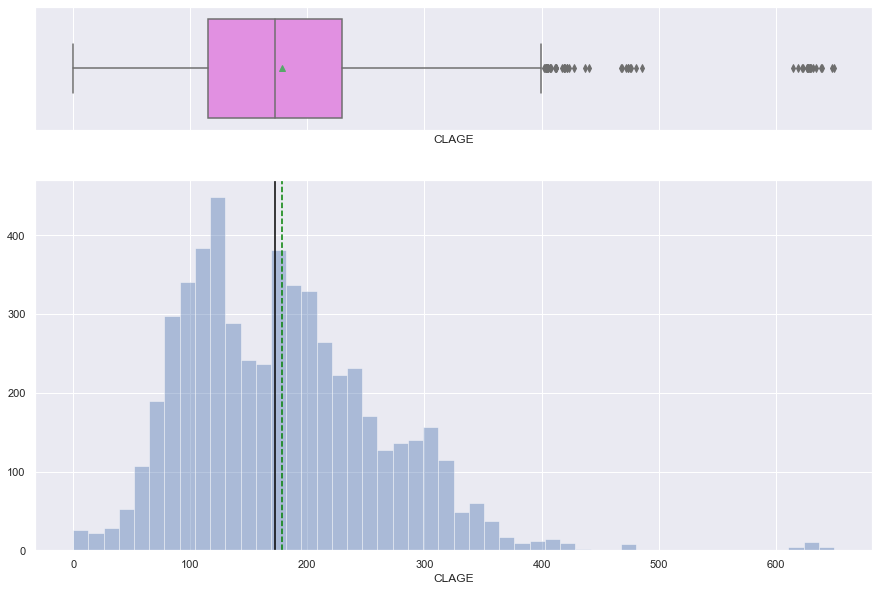

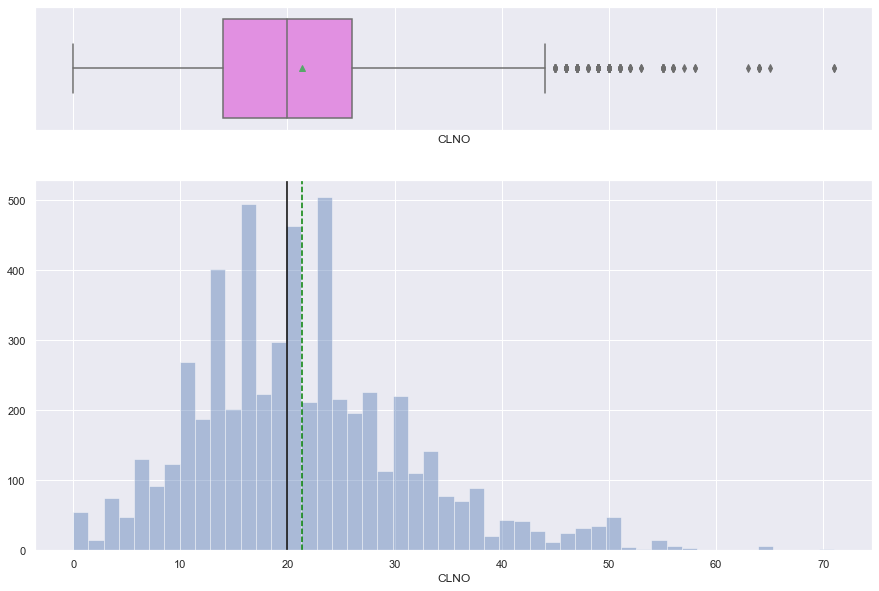

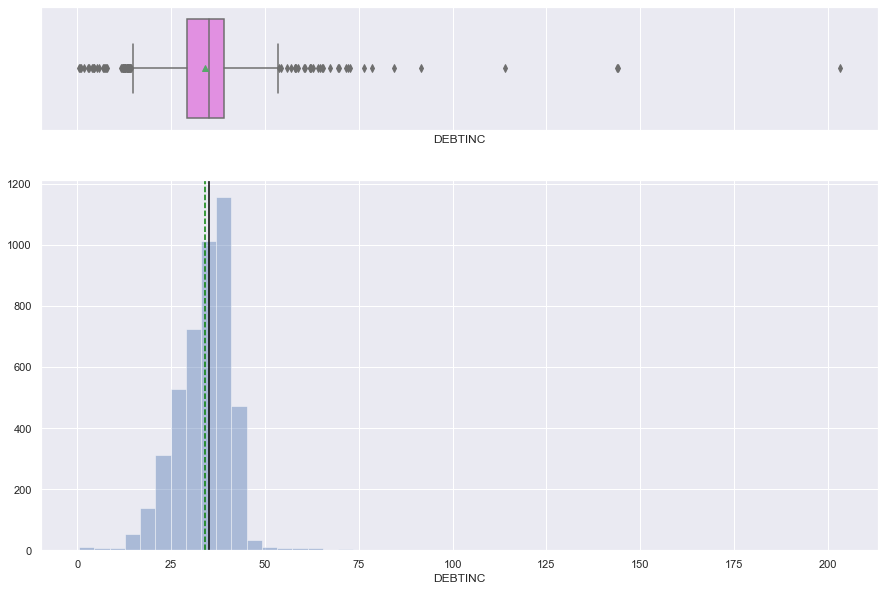

In [46]:
# Build the histogram boxplot for Loan and all numerical features
cols_num = ['LOAN','MORTDUE','VALUE', 'YOJ','CLAGE', 'CLNO', 'DEBTINC']

for i in cols_num:
   histogram_boxplot(data[i])

**Insights __________**

1. Loan amount , mortgage due ,  value of property and debt to income ratio follows the normal distribution with clear outliers on the high-value end.
2. Years in present job gradually skews to the right with the more than 800  (12%) of the loaners only in the present job from 1 yr or less.
3. The age of the oldest credit line has 2 peaks with outliers after 33 months.

### Univariate Analysis - Categorical Data

In [47]:
# Function to create barplots that indicate percentage for each category.

def perc_on_bar(plot, feature):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''

    total = len(feature) # length of the column
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # height of the plot
        ax.annotate(percentage, (x, y), size = 12) # annotate the percentage 
        
    plt.show() # show the plot

#### Analyze Barplot for DEROG, DELINQ, NINQ

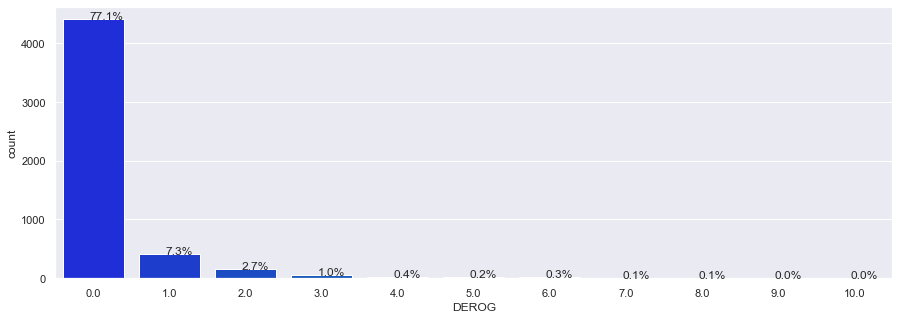

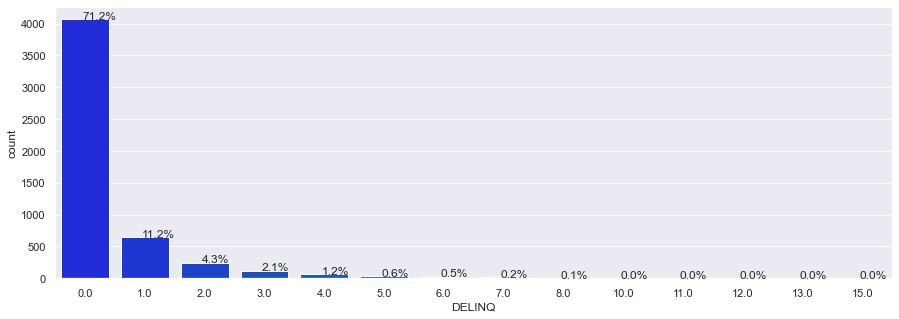

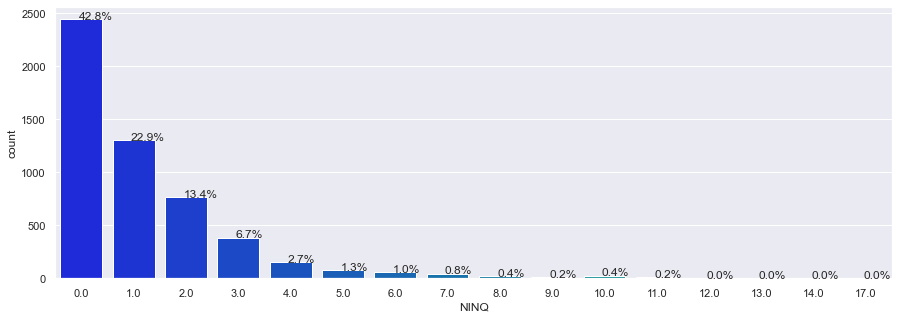

In [48]:
#Build barplot for DELINQ and other features with values that are mostly 0s, 
#treating them like categorical values even if they are of float data types.
cols_cat_num = ['DEROG','DELINQ','NINQ']
for i in cols_cat_num:
    plt.figure(figsize=(15,5))
    ax = sns.countplot(data[i],palette='winter')
    perc_on_bar(ax,data[i])

**Insights ________**
1. Majority of the loan records have 0  major derogatory reports and 0 delinquent credit lines.
2. 43% of the loans have 0 recent credit inquiries, the majority at 5 inquiries or less, and the rest as outliers.
3. The above are expected since only 20% of the loans are defaults. The majority of loaners should have good credit records and low credit inquiries.

## Bivariate Analysis

### Analyze BAD vs continuous variables

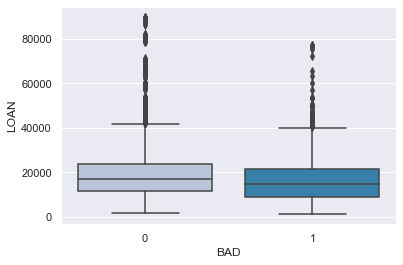

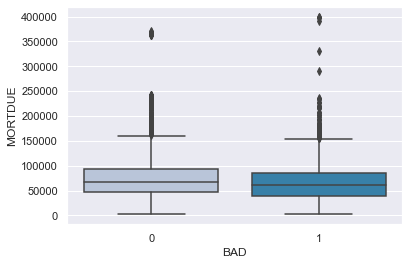

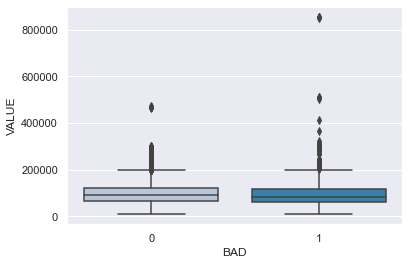

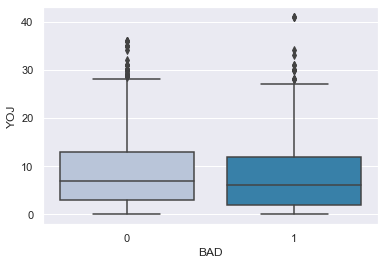

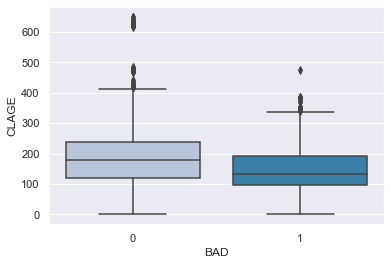

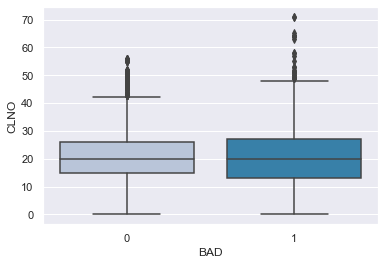

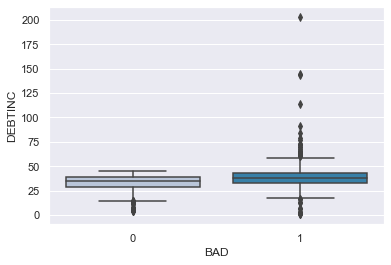

In [49]:
# BAD vs continuous values
for i in cols_num:
    sns.boxplot(data["BAD"],data[i],palette="PuBu")
    plt.show()

In [50]:
data.groupby(['BAD'])[cols_num].median()

LOAN  MORTDUE    VALUE  YOJ  CLAGE  CLNO  DEBTINC
BAD                                                      
0   17000.00 66892.50 90883.00 7.00 179.44 20.00    34.71
1   14800.00 60301.00 81922.00 6.00 132.40 20.00    38.14

In [51]:
data.groupby(['BAD'])[cols_num].quantile(0.75)

LOAN  MORTDUE     VALUE   YOJ  CLAGE  CLNO  DEBTINC
BAD                                                        
0   23800.00 93042.75 120235.50 13.00 238.59 26.00    38.85
1   21400.00 85845.00 116000.00 12.00 192.72 27.00    43.32

**Insights ______**

1. The amount of the loan for both defaulted and good loans almost have the same range of values, both with outliers from the same point as well, indicating that the loan amount by itself is not a likely predictor of good and bad loans.
2. The remaining mortgage due and the value of the property have almost similar range values for both good and bad loans.
3. In the years in the present job, the defaulters’ range of values is slightly lower, meaning there’s a higher percentage of defaulters who are new in their current job roles.
4. The age of the oldest credit lines is slightly lower for defaulters which may mean that good creditors have more history of good credit.
5.	Bad loans have a wider range of number of credit lines than good loans.
6.	As expected, the debt-to-income(DTI) ratio for bad loans is higher compared to good loans.  


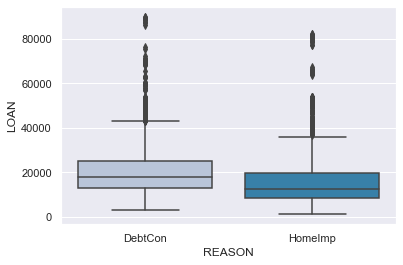

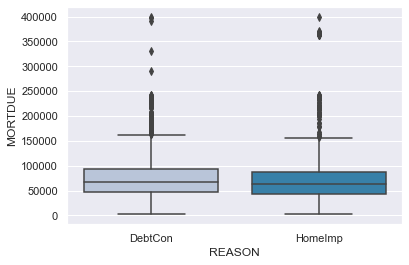

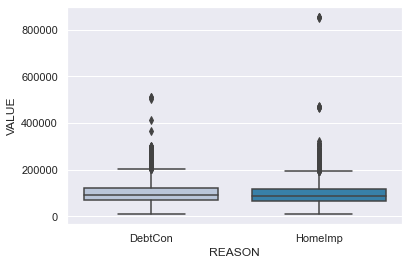

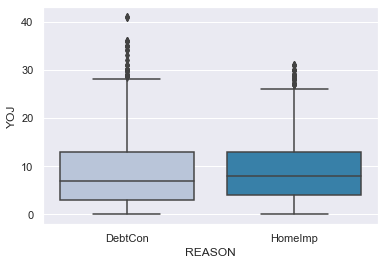

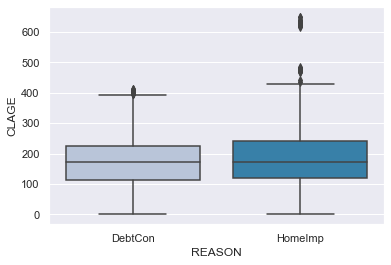

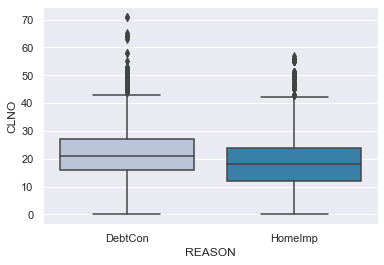

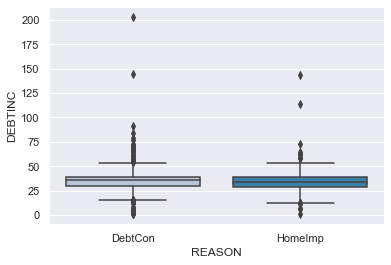

In [52]:
# REASON vs numeric values
for i in cols_num:
    sns.boxplot(data["REASON"],data[i],palette="PuBu")
    plt.show()

In [53]:
cols_num_ninq = cols_num + ['NINQ']

In [54]:
data.groupby(['REASON'])[cols_num_ninq].median()

LOAN  MORTDUE    VALUE  YOJ  CLAGE  CLNO  DEBTINC  NINQ
REASON                                                             
DebtCon 18000.00 66400.00 90467.50 7.00 172.43 21.00    35.33  1.00
HomeImp 12600.00 63134.50 87178.00 8.00 171.95 18.00    34.23  0.00

In [55]:
data.groupby(['REASON'])[cols_num_ninq].quantile(0.75)

LOAN  MORTDUE     VALUE   YOJ  CLAGE  CLNO  DEBTINC  NINQ
REASON                                                               
DebtCon 25000.00 93413.00 121818.50 13.00 225.35 27.00    39.30  2.00
HomeImp 19500.00 87984.25 115191.00 13.00 242.39 24.00    38.68  1.00

**Insights: _____**

There is not much difference in range values of continuous variables between debt consolidation and home improvement loan purposes except for the following:
1.	Loan amounts are higher for debt consolidation, which means higher exposure for the bank for debt consolidation.
2.	The number of recent inquiries and number of existing credit lines is higher for debt consolidation which may be the reasons for wanting to consolidate loans.

### Bivariate Analysis: Two Continuous Variables

<AxesSubplot:xlabel='VALUE', ylabel='MORTDUE'>

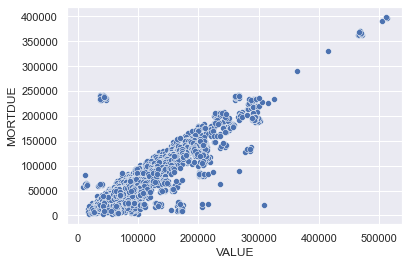

In [56]:
sns.scatterplot(data["VALUE"],data['MORTDUE'],palette="PuBu")

**Insights: _____**

There is a high correlation between the remaining mortgage due and the value of the property indicating that the proportion of remaining mortgage to the value of property are mostly the same.

#### Bivariate Analysis on different pairs of continuous variables

<AxesSubplot:xlabel='VALUE', ylabel='LOAN'>

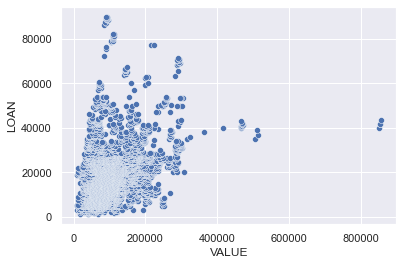

In [57]:
sns.scatterplot(data["VALUE"],data['LOAN'],palette="PuBu")

<AxesSubplot:xlabel='MORTDUE', ylabel='DEBTINC'>

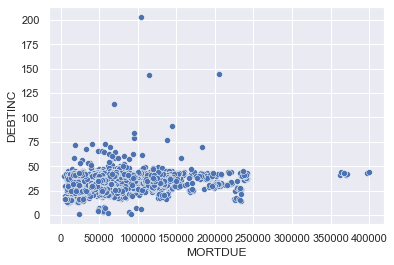

In [58]:
sns.scatterplot(data["MORTDUE"],data['DEBTINC'],palette="PuBu")

**Insights ____________**
1. There are no strong correlations in the above pairs of continuous variables.
2. The above charts confirm the concentration of data in the lower values of loans and remaining mortgages, consistent with the univariate analyses and summary statistics shown earlier.

### Bivariate Analysis:  BAD vs Categorical Variables

**The stacked bar chart (aka stacked bar graph)** extends the standard bar chart from looking at numeric values across one categorical variable to two.

In [59]:
### Function to plot stacked bar charts for categorical columns

def stacked_plot(x):
    sns.set(palette='nipy_spectral')
    tab1 = pd.crosstab(x,data['BAD'],margins=True)
    tab1['% Default'] = tab1[1]/tab1['All']*100
    print('-'*80)
    print(tab1)
    tab = pd.crosstab(x,data['BAD'])
    tab.plot(kind='bar',stacked=True,figsize=(10,5), color = ['green','red'])
    plt.legend(loc='lower left', frameon=False)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.show()

#### Plot stacked bar plot for for BAD vs all other Categorical Variables

In [60]:
# Treat 'DEROG','DELINQ','NINQ' as categorical variables based on univariate analysis
for i in cols_cat_num:
    data[i] = data[i].astype('category')

--------------------------------------------------------------------------------
BAD         0     1   All  % Default
REASON                              
DebtCon  3183   745  3928      18.97
HomeImp  1384   396  1780      22.25
All      4567  1141  5708      19.99


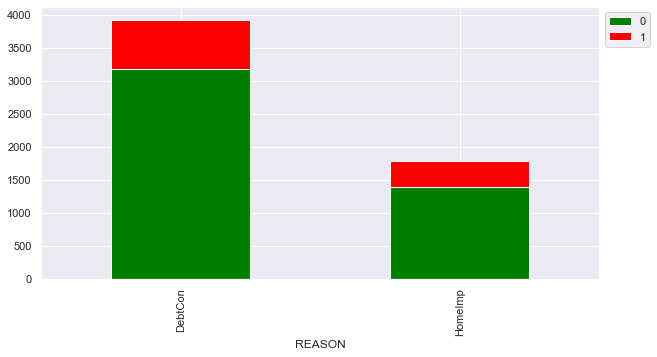

--------------------------------------------------------------------------------
BAD         0     1   All  % Default
JOB                                 
Mgr       574   172   746      23.06
Office    796   125   921      13.57
Other    1782   538  2320      23.19
ProfExe  1050   202  1252      16.13
Sales      71    38   109      34.86
Self      135    53   188      28.19
All      4408  1128  5536      20.38


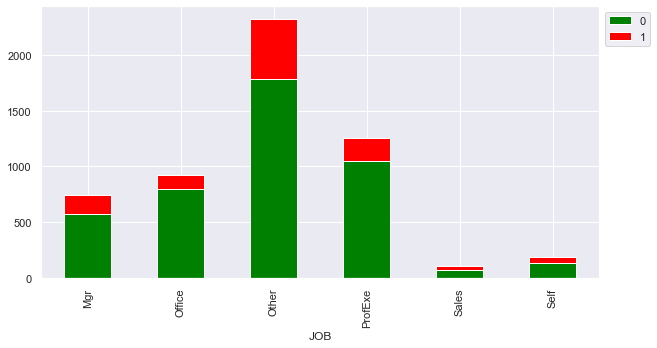

--------------------------------------------------------------------------------
BAD       0     1   All  % Default
DEROG                             
0.0    3670   730  4400      16.59
1.0     254   162   416      38.94
2.0      78    76   154      49.35
3.0      15    42    57      73.68
4.0       5    17    22      77.27
5.0       8     6    14      42.86
6.0       5    10    15      66.67
7.0       0     6     6     100.00
8.0       0     6     6     100.00
9.0       0     2     2     100.00
10.0      0     2     2     100.00
All    4035  1059  5094      20.79


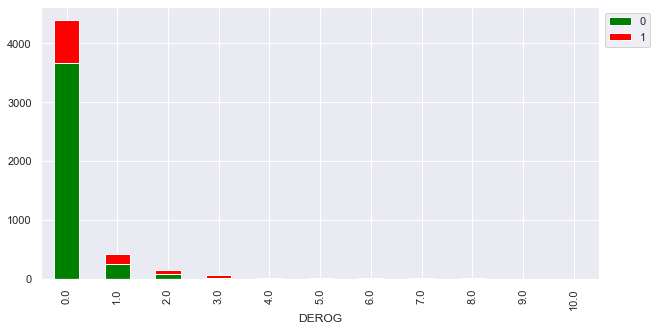

--------------------------------------------------------------------------------
BAD        0     1   All  % Default
DELINQ                             
0.0     3492   572  4064      14.07
1.0      432   210   642      32.71
2.0      138   108   246      43.90
3.0       57    63   120      52.50
4.0       28    41    69      59.42
5.0        3    29    32      90.62
6.0        0    26    26     100.00
7.0        0    13    13     100.00
8.0        0     5     5     100.00
10.0       0     2     2     100.00
11.0       0     2     2     100.00
12.0       0     1     1     100.00
13.0       0     1     1     100.00
15.0       0     1     1     100.00
All     4150  1074  5224      20.56


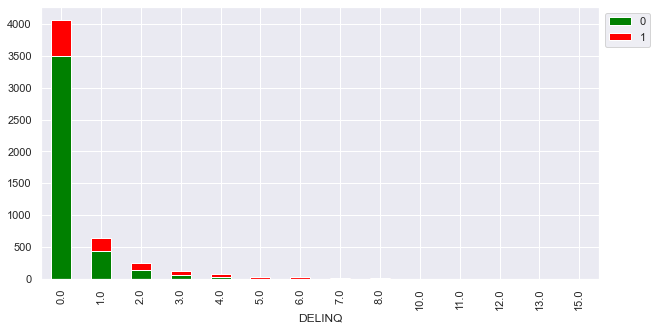

--------------------------------------------------------------------------------
BAD      0     1   All  % Default
NINQ                             
0.0   2057   384  2441      15.73
1.0   1059   246  1305      18.85
2.0    594   173   767      22.56
3.0    281   101   382      26.44
4.0     95    59   154      38.31
5.0     39    35    74      47.30
6.0     27    28    55      50.91
7.0     29    15    44      34.09
8.0     11    11    22      50.00
9.0      5     6    11      54.55
10.0    19     6    25      24.00
11.0     7     3    10      30.00
12.0     0     2     2     100.00
13.0     0     2     2     100.00
14.0     0     1     1     100.00
17.0     0     1     1     100.00
All   4223  1073  5296      20.26


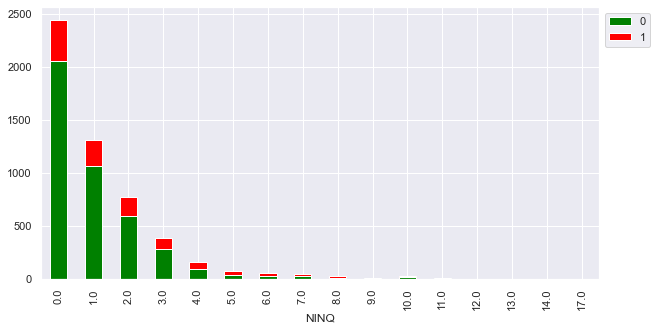

In [61]:
cat_data = data.select_dtypes('category').columns.tolist()
cat_data.remove('BAD')
#print(cat_data)

for i in cat_data:
    stacked_plot(data[i])
    

**Insights ___________________**

1.	Loan defaults hover around 20% for both types of loan reasons with default just slightly higher for home improvement loans. 
2.	Sales-related and self-employment job categories show higher percentages of default maybe indicating that consistent income is more favorable for servicing loans.
3.	There are bad loans even if the borrowers have no past derogatory reports and no delinquent credit lines indicating that past behavior cannot be the sole basis for loan approval.
4.	The percentage of bad loans seems to increase as the number of derogatory reports increases but lowered a bit at values 5 and 6. There are no more good loans when there are 7 or more derogatory reports in this data set. Although these are in very small numbers (less than ~1%).
5.	The percentage of bad loans increases as the number of delinquent credit lines. 6 or higher delinquent credit lines all resulted in bad loans, although these are less than 1% of the test data.
6.	The percentage of bad loans is above 30% for the number of recent inquiries at 4 and higher. There are no more good loans when the number of recent inquiries reaches 12, although these are very few (6 out of 5000+ records).

## Multivariate Analysis

### Analyze Correlation Heatmap for Numerical Variables

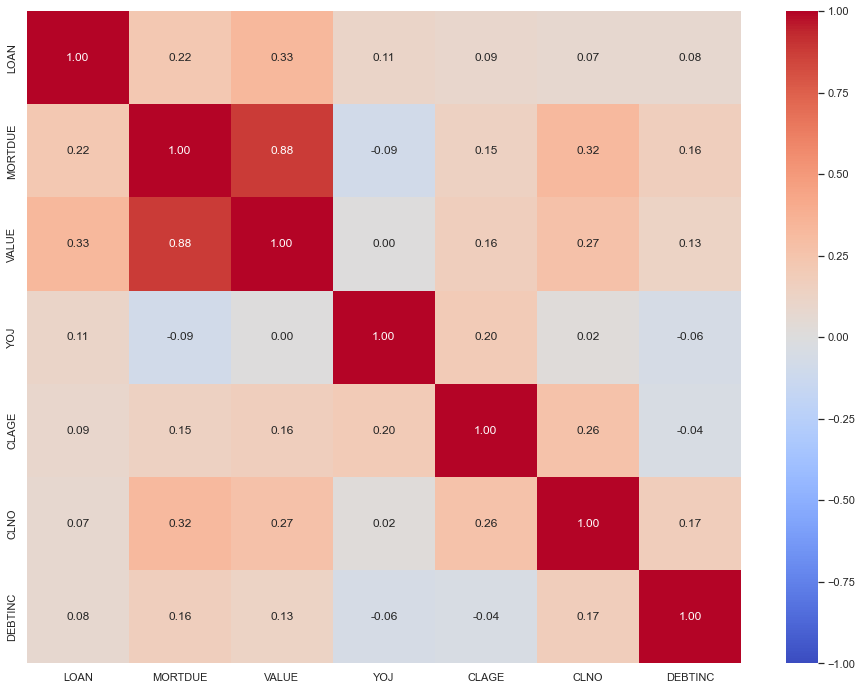

In [62]:
# Separating numerical variables
numerical_col = data.select_dtypes(include=np.number).columns.tolist()

# Build correlation matrix for numerical columns
corr = data[numerical_col].corr()

# plot the heatmap
plt.figure(figsize=(16,12))
sns.heatmap(corr,annot=True,cmap='coolwarm',vmax=1,vmin=-1,
        fmt=".2f",
        xticklabels=corr.columns,
        yticklabels=corr.columns);

**Insights ____________**

1. As seen earlier, there is a strong correlation between the remaining mortgage and the value of the property.
2. There is a slight correlation between the amount of the loan and the value of the property. Maybe the lender provides a higher loan based on the value of the property.
3. Other than these, there are no other observed significant positive or negative correlations.

### Analyze Correlation Heatmap and Pair Plot for Numerical Variables

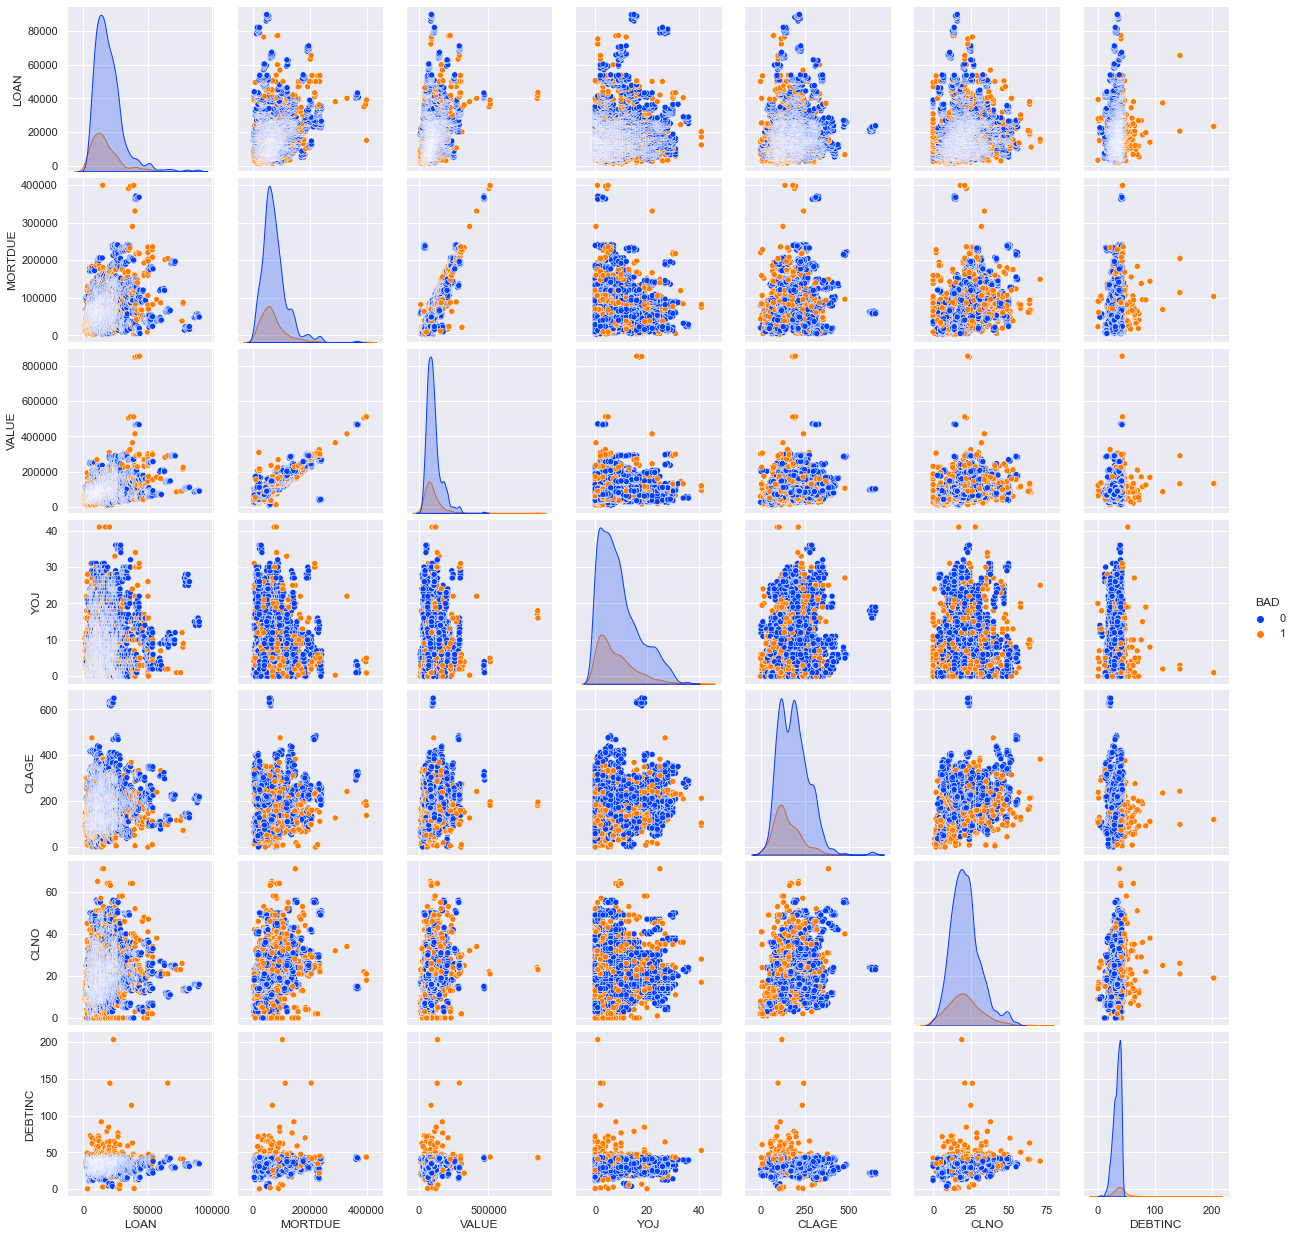

In [63]:
# Build pairplot for the data with hue = 'BAD'
sns.pairplot(data, hue='BAD',palette='bright')

**Insights ____________**

1. Unexpectedly, the small cluster of data with a high remaining mortgage due over property value show as good loans. Bad loans are scattered all over the value-pair not showing any other good vs bad loan clusters.
2. Higher values of the number of debt-to-income ratios show a higher concentration of defaulted loans as expected.
3. Higher values of the loan amount and remaining mortgage do not seem to affect the loan default outcomes.
4. The pair plot does not show a clear relationship between the number of years in a job and loan defaults.


## Treat missing values and outliers

**Think about it**
- Are there missing values and outliers in the dataset? If yes, how can you treat them? 
- Can you think of different ways in which this can be done and when to treat these outliers or not?
- Can we create new features based on Missing values?

### Add new columns in the dataset for each column which has missing values 

As seen earlier when looking at the distribution of bad and good loans where a feature is missing, the proportion of bad vs good loans vary and some are higher than that of the data sets. Strikingly, for records with missing value property, the default rate is more than 90%. To see how missing features impact the model, the missing value has to be tagged before they are imputed.

In [64]:
#For each column we create a binary flag for the row, if there is missing value in the row, then 1 else 0. 
def add_binary_flag(df,col):
    '''
    df: It is the dataframe
    col: it is column which has missing values
    It returns a dataframe which has binary falg for missing values in column col
    '''
    new_col = str(col)
    new_col += '_missing_values_flag'
    df[new_col] = data[col].isna() #Have to use dataframe before missing values were treated
    return new_col

In [65]:
#Save data before any treatment
df = data.copy()

In [66]:
# Add missing value flags to 2 data sets
missing_col = [col for col in df.columns if df[col].isnull().any()]
cols_missing_flags = []
for i in missing_col:
    new_col=add_binary_flag(df,i)
    cols_missing_flags.append(new_col)

In [67]:
print (cols_missing_flags)

['MORTDUE_missing_values_flag', 'VALUE_missing_values_flag', 'JOB_missing_values_flag', 'YOJ_missing_values_flag', 'DEROG_missing_values_flag', 'DELINQ_missing_values_flag', 'CLAGE_missing_values_flag', 'NINQ_missing_values_flag', 'CLNO_missing_values_flag', 'DEBTINC_missing_values_flag']


In [68]:
#Check dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5708 entries, 0 to 5959
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   BAD                          5708 non-null   category
 1   LOAN                         5708 non-null   int64   
 2   MORTDUE                      5273 non-null   float64 
 3   VALUE                        5616 non-null   float64 
 4   REASON                       5708 non-null   category
 5   JOB                          5536 non-null   category
 6   YOJ                          5297 non-null   float64 
 7   DEROG                        5094 non-null   category
 8   DELINQ                       5224 non-null   category
 9   CLAGE                        5504 non-null   float64 
 10  NINQ                         5296 non-null   category
 11  CLNO                         5571 non-null   float64 
 12  DEBTINC                      4497 non-null   float64 
 13  MOR

In [69]:
#spot check flag values
df['DEBTINC_missing_values_flag'].value_counts(dropna=False,normalize=True)

False   0.79
True    0.21
Name: DEBTINC_missing_values_flag, dtype: float64

### Treat missing values with KNN Imputer

Moved the code block to treat outliers later and treat missing values first

#### Prepare data for treating missing values with KNN Imputer

1. Encode categorical values into integers.
2. Impute missing values using KNNImputer.
3. Return categorical values to original form.

In [70]:
# change numerical categories into integer
print (cols_cat_num)

['DEROG', 'DELINQ', 'NINQ']


In [71]:
for i in cols_cat_num+['BAD']:
    df[i] = df[i].astype('Int32')

In [72]:
# we need to pass numerical values for each catergorical column for KNN imputation so we will label encode them
# listing the distribution here before changing them
cols_cat = df.select_dtypes(['category'])

In [73]:
for i in cols_cat.columns:
    print('Unique values in',i, 'are :')
    print(df[i].value_counts(dropna=False,normalize=True,ascending=True).sort_index(ascending=True))
    print('*'*40)

Unique values in REASON are :
DebtCon   0.69
HomeImp   0.31
Name: REASON, dtype: float64
****************************************
Unique values in JOB are :
Mgr       0.13
Office    0.16
Other     0.41
ProfExe   0.22
Sales     0.02
Self      0.03
NaN       0.03
Name: JOB, dtype: float64
****************************************


In [74]:
reason = {'DebtCon':0,'HomeImp':1}
df['REASON'] = df['REASON'].map(reason).astype('Int32')

job= {'Mgr':0, 'Office':1,'Other':2, 'ProfExe':3,'Sales':4,'Self':5}  
df['JOB'] = df['JOB'].map(job).astype('Int32')

In [75]:
#check encoding
df.head()

BAD  LOAN  MORTDUE     VALUE  REASON  JOB   YOJ  DEROG  DELINQ  CLAGE  ...  \
0    1  1100 25860.00  39025.00       1    2 10.50      0       0  94.37  ...   
1    1  1300 70053.00  68400.00       1    2  7.00      0       2 121.83  ...   
2    1  1500 13500.00  16700.00       1    2  4.00      0       0 149.47  ...   
4    0  1700 97800.00 112000.00       1    1  3.00      0       0  93.33  ...   
5    1  1700 30548.00  40320.00       1    2  9.00      0       0 101.47  ...   

   MORTDUE_missing_values_flag  VALUE_missing_values_flag  \
0                        False                      False   
1                        False                      False   
2                        False                      False   
4                        False                      False   
5                        False                      False   

   JOB_missing_values_flag  YOJ_missing_values_flag  \
0                    False                    False   
1                    False                    False   
2                    False                    False   
4                    False                    False   
5                    False                    False   

   DEROG_missing_values_flag  DELINQ_missing_values_flag  \
0                      False                       False   
1                      False                       False   
2                      False                       False   
4                      False                       False   
5                      False                       False   

   CLAGE_missing_values_flag  NINQ_missing_values_flag  \
0                      False                     False   
1                      False                     False   
2                      False                     False   
4                      False                     False   
5                      False                     False   

   CLNO_missing_values_flag  DEBTINC_missing_values_flag  
0                     False                         True  
1                     False                         True  
2                     False                         True  
4                     False                         True  
5                     False                        False  

[5 rows x 23 columns]

In [76]:
df.tail()

BAD   LOAN  MORTDUE    VALUE  REASON  JOB   YOJ  DEROG  DELINQ  CLAGE  \
5955    0  88900 57264.00 90185.00       0    2 16.00      0       0 221.81   
5956    0  89000 54576.00 92937.00       0    2 16.00      0       0 208.69   
5957    0  89200 54045.00 92924.00       0    2 15.00      0       0 212.28   
5958    0  89800 50370.00 91861.00       0    2 14.00      0       0 213.89   
5959    0  89900 48811.00 88934.00       0    2 15.00      0       0 219.60   

      ...  MORTDUE_missing_values_flag  VALUE_missing_values_flag  \
5955  ...                        False                      False   
5956  ...                        False                      False   
5957  ...                        False                      False   
5958  ...                        False                      False   
5959  ...                        False                      False   

      JOB_missing_values_flag  YOJ_missing_values_flag  \
5955                    False                    False   
5956                    False                    False   
5957                    False                    False   
5958                    False                    False   
5959                    False                    False   

      DEROG_missing_values_flag  DELINQ_missing_values_flag  \
5955                      False                       False   
5956                      False                       False   
5957                      False                       False   
5958                      False                       False   
5959                      False                       False   

      CLAGE_missing_values_flag  NINQ_missing_values_flag  \
5955                      False                     False   
5956                      False                     False   
5957                      False                     False   
5958                      False                     False   
5959                      False                     False   

      CLNO_missing_values_flag  DEBTINC_missing_values_flag  
5955                     False                        False  
5956                     False                        False  
5957                     False                        False  
5958                     False                        False  
5959                     False                        False  

[5 rows x 23 columns]

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5708 entries, 0 to 5959
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BAD                          5708 non-null   Int32  
 1   LOAN                         5708 non-null   int64  
 2   MORTDUE                      5273 non-null   float64
 3   VALUE                        5616 non-null   float64
 4   REASON                       5708 non-null   Int32  
 5   JOB                          5536 non-null   Int32  
 6   YOJ                          5297 non-null   float64
 7   DEROG                        5094 non-null   Int32  
 8   DELINQ                       5224 non-null   Int32  
 9   CLAGE                        5504 non-null   float64
 10  NINQ                         5296 non-null   Int32  
 11  CLNO                         5571 non-null   float64
 12  DEBTINC                      4497 non-null   float64
 13  MORTDUE_missing_va

In [78]:
df.isnull().sum()

BAD                               0
LOAN                              0
MORTDUE                         435
VALUE                            92
REASON                            0
JOB                             172
YOJ                             411
DEROG                           614
DELINQ                          484
CLAGE                           204
NINQ                            412
CLNO                            137
DEBTINC                        1211
MORTDUE_missing_values_flag       0
VALUE_missing_values_flag         0
JOB_missing_values_flag           0
YOJ_missing_values_flag           0
DEROG_missing_values_flag         0
DELINQ_missing_values_flag        0
CLAGE_missing_values_flag         0
NINQ_missing_values_flag          0
CLNO_missing_values_flag          0
DEBTINC_missing_values_flag       0
dtype: int64

**Impute Missing Values using KNNImputer**

KNNImputer: Each sample's missing values are imputed by looking at the n_neighbors nearest neighbors found in the training set. Default value for n_neighbors=5.
KNN imputer replaces missing values using the average of k nearest non-missing feature values.
Nearest points are found based on euclidean distance.

In [79]:
imputer = KNNImputer(n_neighbors=5)

In [80]:
#Fit and transform the train data
df=pd.DataFrame(imputer.fit_transform(df),columns=df.columns)

In [81]:
# Check missing values
df.isnull().sum()

BAD                            0
LOAN                           0
MORTDUE                        0
VALUE                          0
REASON                         0
JOB                            0
YOJ                            0
DEROG                          0
DELINQ                         0
CLAGE                          0
NINQ                           0
CLNO                           0
DEBTINC                        0
MORTDUE_missing_values_flag    0
VALUE_missing_values_flag      0
JOB_missing_values_flag        0
YOJ_missing_values_flag        0
DEROG_missing_values_flag      0
DELINQ_missing_values_flag     0
CLAGE_missing_values_flag      0
NINQ_missing_values_flag       0
CLNO_missing_values_flag       0
DEBTINC_missing_values_flag    0
dtype: int64

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5708 entries, 0 to 5707
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BAD                          5708 non-null   float64
 1   LOAN                         5708 non-null   float64
 2   MORTDUE                      5708 non-null   float64
 3   VALUE                        5708 non-null   float64
 4   REASON                       5708 non-null   float64
 5   JOB                          5708 non-null   float64
 6   YOJ                          5708 non-null   float64
 7   DEROG                        5708 non-null   float64
 8   DELINQ                       5708 non-null   float64
 9   CLAGE                        5708 non-null   float64
 10  NINQ                         5708 non-null   float64
 11  CLNO                         5708 non-null   float64
 12  DEBTINC                      5708 non-null   float64
 13  MORTDUE_missing_va

In [83]:
## Inverse the encoding
def inverse_mapping(x,y):
    inv_dict = {v: k for k, v in x.items()}
    df[y] = np.round(df[y]).map(inv_dict).astype('category')

In [84]:
inverse_mapping(reason,'REASON')
inverse_mapping(job,'JOB')

In [85]:
#These integers were imputed real values, rounding and changing back to int
df[cols_cat_num] = np.round(df[cols_cat_num]).astype(int)

In [86]:
df['BAD'] = df['BAD'].astype(int)

In [87]:
#Return bools
df[cols_missing_flags] = df[cols_missing_flags].astype('bool')

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5708 entries, 0 to 5707
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   BAD                          5708 non-null   int64   
 1   LOAN                         5708 non-null   float64 
 2   MORTDUE                      5708 non-null   float64 
 3   VALUE                        5708 non-null   float64 
 4   REASON                       5708 non-null   category
 5   JOB                          5708 non-null   category
 6   YOJ                          5708 non-null   float64 
 7   DEROG                        5708 non-null   int64   
 8   DELINQ                       5708 non-null   int64   
 9   CLAGE                        5708 non-null   float64 
 10  NINQ                         5708 non-null   int64   
 11  CLNO                         5708 non-null   float64 
 12  DEBTINC                      5708 non-null   float64 
 13  MOR

In [89]:
#Compare old and new data sets
data.describe().T

count      mean      std     min      25%      50%       75%  \
LOAN    5708.00  18722.32 11327.21 1100.00 11100.00 16400.00  23500.00   
MORTDUE 5273.00  73950.00 44543.60 2063.00 46451.00 65178.00  91491.00   
VALUE   5616.00 102018.00 57798.04 8000.00 66244.75 89571.00 119613.75   
YOJ     5297.00      8.89     7.52    0.00     3.00     7.00     13.00   
CLAGE   5504.00    178.60    83.65    0.00   114.83   172.35    229.52   
CLNO    5571.00     21.36    10.12    0.00    14.00    20.00     26.00   
DEBTINC 4497.00     34.00     8.25    0.52    29.30    34.98     39.11   

              max  
LOAN     89900.00  
MORTDUE 399550.00  
VALUE   855909.00  
YOJ         41.00  
CLAGE      649.75  
CLNO        71.00  
DEBTINC    203.31

In [90]:
df.describe(include='float64').T

count      mean      std     min      25%      50%       75%  \
LOAN    5708.00  18722.32 11327.21 1100.00 11100.00 16400.00  23500.00   
MORTDUE 5708.00  73017.37 43476.86 2063.00 46406.00 64371.40  90001.50   
VALUE   5708.00 101575.05 57737.55 8000.00 65777.00 89020.50 119202.25   
YOJ     5708.00      8.92     7.34    0.00     3.00     7.00     13.00   
CLAGE   5708.00    178.14    82.51    0.00   115.81   171.49    227.36   
CLNO    5708.00     21.32    10.03    0.00    15.00    20.00     26.00   
DEBTINC 5708.00     33.65     7.69    0.52    29.32    34.27     38.51   

              max  
LOAN     89900.00  
MORTDUE 399550.00  
VALUE   855909.00  
YOJ         41.00  
CLAGE      649.75  
CLNO        71.00  
DEBTINC    203.31

In [91]:
data.describe(include=['category']).T

count unique      top    freq
BAD       5708      2        0    4567
REASON    5708      2  DebtCon    3928
JOB       5536      6    Other    2320
DEROG  5094.00  11.00     0.00 4400.00
DELINQ 5224.00  14.00     0.00 4064.00
NINQ   5296.00  16.00     0.00 2441.00

In [92]:
df.describe(include=['category']).T

count unique      top  freq
REASON  5708      2  DebtCon  3928
JOB     5708      6    Other  2454

In [93]:
df[cols_cat_num].describe().T

count  mean  std  min  25%  50%  75%   max
DEROG  5708.00  0.27 0.81 0.00 0.00 0.00 0.00 10.00
DELINQ 5708.00  0.51 1.14 0.00 0.00 0.00 1.00 15.00
NINQ   5708.00  1.19 1.68 0.00 0.00 1.00 2.00 17.00

In [94]:
#Save data treated with missing values
df.to_csv('noMV_hemq.csv',index=False)
noMV_df = df.copy()

## Treat outliers

In [95]:
def treat_outliers(df,col):
    '''
    treats outliers in a varaible
    col: str, name of the numerical varaible
    df: data frame
    col: name of the column
    '''
    
    Q1=df[col].quantile(0.25) # 25th quantile
    Q3=df[col].quantile(0.75)  # 75th quantile
    IQR=Q3-Q1   # IQR Range
    Lower_Whisker = Q1-1.5*IQR  #define lower whisker
    Upper_Whisker = Q3+1.5*IQR  # define upper Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker) # all the values samller than Lower_Whisker will be assigned value of Lower_whisker 
                                                            # and all the values above upper_whishker will be assigned value of upper_Whisker 
    
    #print(col,Q1,Q3,Lower_Whisker,Upper_Whisker)
    return df

def treat_outliers_all(df, col_list):
    '''
    treat outlier in all numerical varaibles
    col_list: list of numerical varaibles
    df: data frame
    '''
    for c in col_list:
        df = treat_outliers(df,c)
        
    return df

In [96]:
print(cols_num)

['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'CLAGE', 'CLNO', 'DEBTINC']


In [97]:
df = treat_outliers_all(df,cols_num)

In [98]:
#Compare b4 (data) and after (df)

In [99]:
data.describe().T

count      mean      std     min      25%      50%       75%  \
LOAN    5708.00  18722.32 11327.21 1100.00 11100.00 16400.00  23500.00   
MORTDUE 5273.00  73950.00 44543.60 2063.00 46451.00 65178.00  91491.00   
VALUE   5616.00 102018.00 57798.04 8000.00 66244.75 89571.00 119613.75   
YOJ     5297.00      8.89     7.52    0.00     3.00     7.00     13.00   
CLAGE   5504.00    178.60    83.65    0.00   114.83   172.35    229.52   
CLNO    5571.00     21.36    10.12    0.00    14.00    20.00     26.00   
DEBTINC 4497.00     34.00     8.25    0.52    29.30    34.98     39.11   

              max  
LOAN     89900.00  
MORTDUE 399550.00  
VALUE   855909.00  
YOJ         41.00  
CLAGE      649.75  
CLNO        71.00  
DEBTINC    203.31

In [100]:
df.describe().T

count     mean      std     min      25%      50%       75%  \
BAD     5708.00     0.20     0.40    0.00     0.00     0.00      0.00   
LOAN    5708.00 18169.67  9384.85 1100.00 11100.00 16400.00  23500.00   
MORTDUE 5708.00 70796.01 36102.98 2063.00 46406.00 64371.40  90001.50   
VALUE   5708.00 98159.72 44879.91 8000.00 65777.00 89020.50 119202.25   
YOJ     5708.00     8.88     7.21    0.00     3.00     7.00     13.00   
DEROG   5708.00     0.27     0.81    0.00     0.00     0.00      0.00   
DELINQ  5708.00     0.51     1.14    0.00     0.00     0.00      1.00   
CLAGE   5708.00   177.17    78.74    0.00   115.81   171.49    227.36   
NINQ    5708.00     1.19     1.68    0.00     0.00     1.00      2.00   
CLNO    5708.00    21.06     9.34    0.00    15.00    20.00     26.00   
DEBTINC 5708.00    33.55     6.55   15.53    29.32    34.27     38.51   

              max  
BAD          1.00  
LOAN     42100.00  
MORTDUE 155394.75  
VALUE   199340.12  
YOJ         28.00  
DEROG       10.00  
DELINQ      15.00  
CLAGE      394.69  
NINQ        17.00  
CLNO        42.50  
DEBTINC     52.29

In [101]:
#Save this data set - no missing values, no outliers
df.to_csv('noMV_noOL_hemq.csv',index=False)
noMV_noOL_df = df.copy()

# Model Building - Approach
1. Data preparation
2. Partition the data into train and test set
3. Fit on the train data
4. Tune the model and prune the tree, if required
5. Test the model on test set

## Logistic Regression

In [102]:
### Read and review the dataset

In [103]:
#For logistical regression, use the variables where the outliers were treated
#hm=pd.read_csv("noMV_noOL_hemq.csv")
hm=noMV_noOL_df

In [104]:
hm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5708 entries, 0 to 5707
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   BAD                          5708 non-null   int64   
 1   LOAN                         5708 non-null   float64 
 2   MORTDUE                      5708 non-null   float64 
 3   VALUE                        5708 non-null   float64 
 4   REASON                       5708 non-null   category
 5   JOB                          5708 non-null   category
 6   YOJ                          5708 non-null   float64 
 7   DEROG                        5708 non-null   int64   
 8   DELINQ                       5708 non-null   int64   
 9   CLAGE                        5708 non-null   float64 
 10  NINQ                         5708 non-null   int64   
 11  CLNO                         5708 non-null   float64 
 12  DEBTINC                      5708 non-null   float64 
 13  MOR

In [105]:
hm.describe().T

count     mean      std     min      25%      50%       75%  \
BAD     5708.00     0.20     0.40    0.00     0.00     0.00      0.00   
LOAN    5708.00 18169.67  9384.85 1100.00 11100.00 16400.00  23500.00   
MORTDUE 5708.00 70796.01 36102.98 2063.00 46406.00 64371.40  90001.50   
VALUE   5708.00 98159.72 44879.91 8000.00 65777.00 89020.50 119202.25   
YOJ     5708.00     8.88     7.21    0.00     3.00     7.00     13.00   
DEROG   5708.00     0.27     0.81    0.00     0.00     0.00      0.00   
DELINQ  5708.00     0.51     1.14    0.00     0.00     0.00      1.00   
CLAGE   5708.00   177.17    78.74    0.00   115.81   171.49    227.36   
NINQ    5708.00     1.19     1.68    0.00     0.00     1.00      2.00   
CLNO    5708.00    21.06     9.34    0.00    15.00    20.00     26.00   
DEBTINC 5708.00    33.55     6.55   15.53    29.32    34.27     38.51   

              max  
BAD          1.00  
LOAN     42100.00  
MORTDUE 155394.75  
VALUE   199340.12  
YOJ         28.00  
DEROG       10.00  
DELINQ      15.00  
CLAGE      394.69  
NINQ        17.00  
CLNO        42.50  
DEBTINC     52.29

In [106]:
hm.shape

(5708, 23)

In [107]:
hm.head()

BAD    LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
0    1 1100.00 25860.00  39025.00  HomeImp   Other 10.50      0       0   
1    1 1300.00 70053.00  68400.00  HomeImp   Other  7.00      0       2   
2    1 1500.00 13500.00  16700.00  HomeImp   Other  4.00      0       0   
3    0 1700.00 97800.00 112000.00  HomeImp  Office  3.00      0       0   
4    1 1700.00 30548.00  40320.00  HomeImp   Other  9.00      0       0   

   CLAGE  ...  MORTDUE_missing_values_flag  VALUE_missing_values_flag  \
0  94.37  ...                        False                      False   
1 121.83  ...                        False                      False   
2 149.47  ...                        False                      False   
3  93.33  ...                        False                      False   
4 101.47  ...                        False                      False   

   JOB_missing_values_flag  YOJ_missing_values_flag  \
0                    False                    False   
1                    False                    False   
2                    False                    False   
3                    False                    False   
4                    False                    False   

   DEROG_missing_values_flag  DELINQ_missing_values_flag  \
0                      False                       False   
1                      False                       False   
2                      False                       False   
3                      False                       False   
4                      False                       False   

   CLAGE_missing_values_flag  NINQ_missing_values_flag  \
0                      False                     False   
1                      False                     False   
2                      False                     False   
3                      False                     False   
4                      False                     False   

   CLNO_missing_values_flag  DEBTINC_missing_values_flag  
0                     False                         True  
1                     False                         True  
2                     False                         True  
3                     False                         True  
4                     False                        False  

[5 rows x 23 columns]

In [108]:
hm.tail()

BAD     LOAN  MORTDUE    VALUE   REASON    JOB   YOJ  DEROG  DELINQ  \
5703    0 42100.00 57264.00 90185.00  DebtCon  Other 16.00      0       0   
5704    0 42100.00 54576.00 92937.00  DebtCon  Other 16.00      0       0   
5705    0 42100.00 54045.00 92924.00  DebtCon  Other 15.00      0       0   
5706    0 42100.00 50370.00 91861.00  DebtCon  Other 14.00      0       0   
5707    0 42100.00 48811.00 88934.00  DebtCon  Other 15.00      0       0   

      CLAGE  ...  MORTDUE_missing_values_flag  VALUE_missing_values_flag  \
5703 221.81  ...                        False                      False   
5704 208.69  ...                        False                      False   
5705 212.28  ...                        False                      False   
5706 213.89  ...                        False                      False   
5707 219.60  ...                        False                      False   

      JOB_missing_values_flag  YOJ_missing_values_flag  \
5703                    False                    False   
5704                    False                    False   
5705                    False                    False   
5706                    False                    False   
5707                    False                    False   

      DEROG_missing_values_flag  DELINQ_missing_values_flag  \
5703                      False                       False   
5704                      False                       False   
5705                      False                       False   
5706                      False                       False   
5707                      False                       False   

      CLAGE_missing_values_flag  NINQ_missing_values_flag  \
5703                      False                     False   
5704                      False                     False   
5705                      False                     False   
5706                      False                     False   
5707                      False                     False   

      CLNO_missing_values_flag  DEBTINC_missing_values_flag  
5703                     False                        False  
5704                     False                        False  
5705                     False                        False  
5706                     False                        False  
5707                     False                        False  

[5 rows x 23 columns]

In [109]:
#Save the read file
df = hm.copy()

### Create dummy variables for the categorical variables


In [110]:
df = pd.get_dummies(data = df, columns = ['REASON','JOB'], drop_first = True) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5708 entries, 0 to 5707
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BAD                          5708 non-null   int64  
 1   LOAN                         5708 non-null   float64
 2   MORTDUE                      5708 non-null   float64
 3   VALUE                        5708 non-null   float64
 4   YOJ                          5708 non-null   float64
 5   DEROG                        5708 non-null   int64  
 6   DELINQ                       5708 non-null   int64  
 7   CLAGE                        5708 non-null   float64
 8   NINQ                         5708 non-null   int64  
 9   CLNO                         5708 non-null   float64
 10  DEBTINC                      5708 non-null   float64
 11  MORTDUE_missing_values_flag  5708 non-null   bool   
 12  VALUE_missing_values_flag    5708 non-null   bool   
 13  JOB_missing_values

### Check for multi-collinearity via VIF

As seen in EDA, mortgage and value has a strong correlation. Checking here if this relationship is strong enough to affect logistical regression by using VIF.

In [111]:
num_feature_set = df.copy()
num_feature_set = add_constant(num_feature_set)
num_feature_set = num_feature_set.astype(float)

In [112]:
vif_series1 = pd.Series([variance_inflation_factor(num_feature_set.values,i) for i in range(num_feature_set.shape[1])],index=num_feature_set.columns, dtype = float)
print('Series before feature selection: \n\n{}\n'.format(vif_series1))

Series before feature selection: 

const                         50.44
BAD                            1.76
LOAN                           1.38
MORTDUE                        3.80
VALUE                          4.33
YOJ                            1.09
DEROG                          1.15
DELINQ                         1.28
CLAGE                          1.23
NINQ                           1.13
CLNO                           1.43
DEBTINC                        1.18
MORTDUE_missing_values_flag    1.42
VALUE_missing_values_flag      1.11
JOB_missing_values_flag        1.14
YOJ_missing_values_flag        1.17
DEROG_missing_values_flag      2.50
DELINQ_missing_values_flag     3.27
CLAGE_missing_values_flag      3.23
NINQ_missing_values_flag       2.46
CLNO_missing_values_flag       3.83
DEBTINC_missing_values_flag    1.49
REASON_HomeImp                 1.18
JOB_Office                     1.94
JOB_Other                      2.60
JOB_ProfExe                    2.21
JOB_Sales                    

**Observations__**

There's some slight multi-collinearity but none strong enough (using threshold of 5) to be worried about. We will proceed with the above set of features.

### Separate the target variable from other variables

In [113]:
# Drop the dependent variable from the dataframe and create the X(independent variable) matrix
# Create y(dependent varialbe)
Y = df.BAD

X = df.drop(['BAD'],axis=1)

### Scale the data

In [114]:
#Scaling the data
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

### Split the data into 70% train and 30% test set

In [115]:
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 1, stratify = Y)

#### Think about it 
- You can try different splits like 70:30 or 80:20 as per your choice. Does this change in split affect the performance?
- If the data is imbalanced, can you make the split more balanced and if yes, how?

**Observations__**
* The 70:30 split seems to be more reasonable given we only have 5000+ records.
* Trying the 80:20 split on a different file did not have better recall in all the models.
* The data is imbalanced and therefore classweights will be assigned where applicable.

### Prepare the model evaluation criteria

After understanding the problem statement, think about which evaluation metrics to consider and why. 

In [116]:
#creating metric function to display confusion matrix 
def metrics_score(actual, predicted):
#    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - Good","Actual - Bad"]],
                  columns = [i for i in ['Predicted - Good','Predicted - Bad']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (4,2))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [117]:
#create a dataframe to store and compare scores
comparison_frame = pd.DataFrame(columns = ['Model','Train_Accuracy','Test_Accuracy',
                                          'Train_Recall','Test_Recall',
                                          'Train_Precision','Test_Precision',
                                          'Train_F1','Test_F1','Model with parameters'])

In [118]:
#create a function to save and compare scores
def show_metrics(alias,x_train,y_train,x_test,y_test,y_pred_train,y_pred_test,model):
    comparison_frame.loc[len(comparison_frame)] = [alias,
        model.score(x_train,y_train),model.score(x_test,y_test),
        metrics.recall_score(y_train,y_pred_train),metrics.recall_score(y_test,y_pred_test),
        metrics.precision_score(y_train,y_pred_train),metrics.precision_score(y_test,y_pred_test),
        metrics.f1_score(y_train,y_pred_train),metrics.f1_score(y_test,y_pred_test),
        str(model)]

### Build a Logistic Regression Model

In [119]:
# Defining the Logistic regression model
lg = LogisticRegression(class_weight= {0: .2, 1: .8})

# Fitting the model on the training data 
lg.fit(x_train,y_train)

LogisticRegression(class_weight={0: 0.2, 1: 0.8})

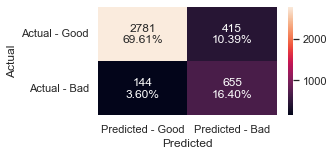

In [120]:
#Predict for train set
y_pred_train = lg.predict(x_train)

#Check the performance on the train dataset
metrics_score(y_train, y_pred_train)

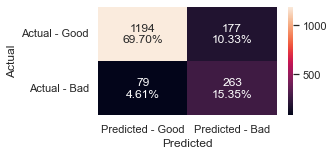

In [121]:
#Predict for test set
y_pred_test = lg.predict(x_test)

#checking the performance on the test dataset
metrics_score(y_test, y_pred_test)

In [122]:
show_metrics('Logistical Regression',x_train,y_train,x_test,y_test, y_pred_train, y_pred_test, lg)

In [123]:
comparison_frame

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
0  Logistical Regression            0.86           0.85          0.82   

   Test_Recall  Train_Precision  Test_Precision  Train_F1  Test_F1  \
0         0.77             0.61            0.60      0.70     0.67   

                               Model with parameters  
0  LogisticRegression(class_weight={0: 0.2, 1: 0.8})

#### Check the coefficients, and check which variables are important and how they affect the process of loan approval

In [124]:
# Printing the coefficients of logistic regression
lg_coef = pd.DataFrame(lg.coef_,columns = X.columns).T.sort_values(by = 0, ascending = False)

In [125]:
lg_coef

0
DEBTINC_missing_values_flag  1.19
VALUE_missing_values_flag    0.94
DELINQ                       0.79
DEBTINC                      0.54
CLNO_missing_values_flag     0.50
DEROG                        0.42
JOB_Sales                    0.26
CLAGE_missing_values_flag    0.25
NINQ                         0.22
MORTDUE_missing_values_flag  0.21
JOB_Other                    0.14
JOB_Self                     0.13
REASON_HomeImp               0.08
VALUE                        0.08
JOB_ProfExe                 -0.01
NINQ_missing_values_flag    -0.03
LOAN                        -0.07
MORTDUE                     -0.09
YOJ                         -0.10
CLNO                        -0.13
JOB_Office                  -0.15
YOJ_missing_values_flag     -0.16
CLAGE                       -0.52
DEROG_missing_values_flag   -0.55
JOB_missing_values_flag     -0.60
DELINQ_missing_values_flag  -0.62

In [126]:
#Save coefficient for reporting
lg_coef.to_csv("LG_coefficients.csv")

**Observations ________**
* Missing values have high positive and negative coefficients. 
* Debt-to-Income (DTI) ratio indicators of previous delinquencies also have high coefficients. 
* As seen earlier, borrowers in sales, self-employed, and others have higher instances of defaults.
* The train and test results are similar. So, the model is generalized.
* The general accuracy is high but the recall is just okay at .77 and precision is low at ~.60. We will need to continue.

#### Check Precision-Recall curve to see a better threshold

**Think about it**
- The above Logistic regression model was build on the threshold of 0.5, can we use different threshold?
- How to get an optimal threshold and which curve will help you achieve?
- How does, accuracy, precision and recall change on the threshold?

In [127]:
from sklearn.metrics import precision_recall_curve

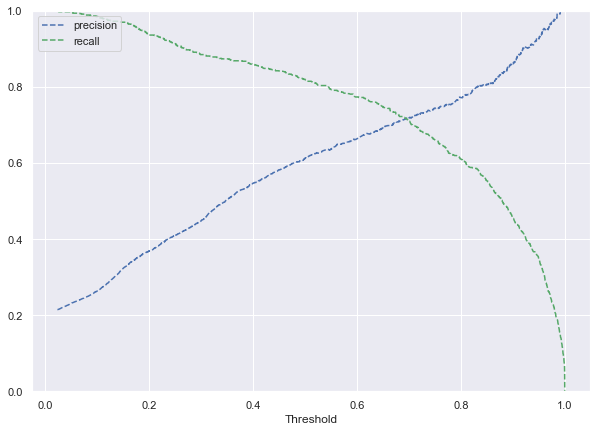

In [128]:
y_scores=lg.predict_proba(x_train)[:,1]
prec, rec, tre = precision_recall_curve(y_train, y_scores,)

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])
plt.figure(figsize=(10,7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

In [129]:
optimal_threshold = 0.7

# Model prediction with optimal threshold
pred_train_opt = (lg.predict_proba(x_train)[:,1]>optimal_threshold)
pred_test_opt = (lg.predict_proba(x_test)[:,1]>optimal_threshold)


In [130]:
comparison_frame.loc[len(comparison_frame)] = ['LG at optimal threshold',accuracy_score(y_train, pred_train_opt),accuracy_score(y_test, pred_test_opt),
                metrics.recall_score(y_train,pred_train_opt),metrics.recall_score(y_test,pred_test_opt),
                metrics.precision_score(y_train,pred_train_opt),metrics.precision_score(y_test,pred_test_opt),
                metrics.f1_score(y_train,pred_train_opt),metrics.f1_score(y_test,pred_test_opt),
                                              str(lg)]
comparison_frame

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
0    Logistical Regression            0.86           0.85          0.82   
1  LG at optimal threshold            0.89           0.88          0.71   

   Test_Recall  Train_Precision  Test_Precision  Train_F1  Test_F1  \
0         0.77             0.61            0.60      0.70     0.67   
1         0.66             0.72            0.70      0.71     0.68   

                               Model with parameters  
0  LogisticRegression(class_weight={0: 0.2, 1: 0.8})  
1  LogisticRegression(class_weight={0: 0.2, 1: 0.8})

**Observations__**
* Total accuracy increased but recall decreased as compared to the previous model.
* As we decrease the threshold value, Recall will increase but the Precision will decrease as seen in the first model where the default threshold is 0.5. 
* Since recall is our priority and we wouldn't want to lower the precision too much, we will stick with the 0.5 threshold.

## Decision Trees

### Think about it:
- In Logistic regression we treated the outliers and built the model, should we do the same for tree based models or not? If not, why?

**Observations:__**

Decision trees can work well with outliers. While DTs can handle outliers, outliers can still 
impact the accuracy of the models. To confirm, we tried using the trimmed data with the Tuned DT and the results were the same and the tree is the same. 

From here on, we will use the data with the outliers.

### Prepare data for the tree based model

In [131]:
#Use the data set were missing values were treated, but not outliers
#data = pd.read_csv("noMV_hemq.csv")
data=noMV_df

In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5708 entries, 0 to 5707
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   BAD                          5708 non-null   int64   
 1   LOAN                         5708 non-null   float64 
 2   MORTDUE                      5708 non-null   float64 
 3   VALUE                        5708 non-null   float64 
 4   REASON                       5708 non-null   category
 5   JOB                          5708 non-null   category
 6   YOJ                          5708 non-null   float64 
 7   DEROG                        5708 non-null   int64   
 8   DELINQ                       5708 non-null   int64   
 9   CLAGE                        5708 non-null   float64 
 10  NINQ                         5708 non-null   int64   
 11  CLNO                         5708 non-null   float64 
 12  DEBTINC                      5708 non-null   float64 
 13  MOR

#### Separate the target variable y and independent variable x and create dummy variables

In [133]:
# Drop dependent variable from dataframe and create the X(independent variable) matrix
# Create y(dependent varibale)
olY = data.BAD
olX = data.drop('BAD', axis =1)

# Create dummy variables for the categorical variables - Hint: use the get_dummies() function
olX = pd.get_dummies(data = olX, columns = ['REASON','JOB'], drop_first = True)      

In [134]:
olX.columns

Index(['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
       'CLNO', 'DEBTINC', 'MORTDUE_missing_values_flag',
       'VALUE_missing_values_flag', 'JOB_missing_values_flag',
       'YOJ_missing_values_flag', 'DEROG_missing_values_flag',
       'DELINQ_missing_values_flag', 'CLAGE_missing_values_flag',
       'NINQ_missing_values_flag', 'CLNO_missing_values_flag',
       'DEBTINC_missing_values_flag', 'REASON_HomeImp', 'JOB_Office',
       'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self'],
      dtype='object')

#### Split the data

In [135]:
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(olX, olY, test_size = 0.3, random_state = 1, stratify = Y)

### Build and test the decision tree model

In [136]:
#Defining Decision tree model with class weights class_weight={0: 0.2, 1: 0.8}
dt = DecisionTreeClassifier(class_weight = {0: 0.2, 1: 0.8}, random_state = 1)

In [137]:
#fitting Decision tree model
dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, random_state=1)

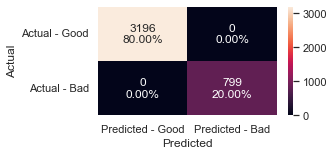

In [138]:
# Checking performance on the training data

y_train_pred_dt = dt.predict(x_train)
metrics_score(y_train, y_train_pred_dt)

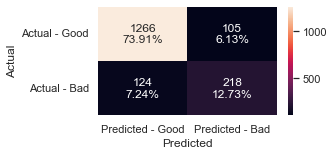

In [139]:
# Checking performance on the testing data

y_test_pred_dt = dt.predict(x_test)
metrics_score(y_test, y_test_pred_dt)

In [140]:
#Show metrics for last 5 models
show_metrics('Decision Tree',x_train,y_train,x_test,y_test, y_train_pred_dt, y_test_pred_dt, dt)

In [141]:
comparison_frame

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
0    Logistical Regression            0.86           0.85          0.82   
1  LG at optimal threshold            0.89           0.88          0.71   
2            Decision Tree            1.00           0.87          1.00   

   Test_Recall  Train_Precision  Test_Precision  Train_F1  Test_F1  \
0         0.77             0.61            0.60      0.70     0.67   
1         0.66             0.72            0.70      0.71     0.68   
2         0.64             1.00            0.67      1.00     0.66   

                               Model with parameters  
0  LogisticRegression(class_weight={0: 0.2, 1: 0.8})  
1  LogisticRegression(class_weight={0: 0.2, 1: 0.8})  
2  DecisionTreeClassifier(class_weight={0: 0.2, 1...

**Observations _____________**

* This tree is overfitting the training data set.


#### Think about it:
- Can we improve this model? 
- How to get optimal parameters in order to get the best possible results?

### Decision Tree - Hyperparameter Tuning

* Hyperparameter tuning is tricky in the sense that **there is no direct way to calculate how a change in the hyperparameter value will reduce the loss of your model**, so we usually resort to experimentation. We'll use Grid search to perform hyperparameter tuning.
* **Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.** 
* **It is an exhaustive search** that is performed on the specific parameter values of a model.
* The parameters of the estimator/model used to apply these methods are **optimized by cross-validated grid-search** over a parameter grid.

**Criterion {“gini”, “entropy”}**

The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

**max_depth** 

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_leaf**

The minimum number of samples is required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

You can learn about more Hyperpapameters on this link and try to tune them. 

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


#### Use GridSearchCV for Hyperparameter tuning on the model

In [142]:
%%time
# Choose the type of classifier. 
dtree_estimator = DecisionTreeClassifier(class_weight = {0: 0.2, 1: 0.8}, random_state = 1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(3, 7), 
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [20, 30, 40]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
gridCV = GridSearchCV(dtree_estimator, parameters, scoring = scorer, cv = 10)

# Fit the GridSearch on train dataset
gridCV = gridCV.fit(x_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = gridCV.best_estimator_

dtree_estimator.fit(x_train, y_train)

CPU times: user 8.14 s, sys: 105 ms, total: 8.24 s
Wall time: 9.21 s


DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, criterion='entropy',
                       max_depth=6, min_samples_leaf=20, random_state=1)

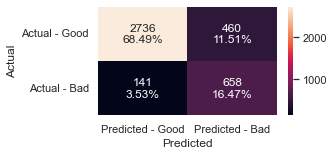

In [143]:
# Checking performance on the training data based on the tuned model

y_train_pred_dt = dtree_estimator.predict(x_train)
metrics_score(y_train, y_train_pred_dt)

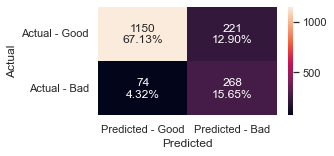

In [144]:
# Checking performance on the testing data based on the tuned model

y_test_pred_dt = dtree_estimator.predict(x_test)
metrics_score(y_test, y_test_pred_dt)

In [145]:
show_metrics('Tuned DT',x_train,y_train,x_test,y_test, y_train_pred_dt, y_test_pred_dt, dtree_estimator)
comparison_frame

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
0    Logistical Regression            0.86           0.85          0.82   
1  LG at optimal threshold            0.89           0.88          0.71   
2            Decision Tree            1.00           0.87          1.00   
3                 Tuned DT            0.85           0.83          0.82   

   Test_Recall  Train_Precision  Test_Precision  Train_F1  Test_F1  \
0         0.77             0.61            0.60      0.70     0.67   
1         0.66             0.72            0.70      0.71     0.68   
2         0.64             1.00            0.67      1.00     0.66   
3         0.78             0.59            0.55      0.69     0.65   

                               Model with parameters  
0  LogisticRegression(class_weight={0: 0.2, 1: 0.8})  
1  LogisticRegression(class_weight={0: 0.2, 1: 0.8})  
2  DecisionTreeClassifier(class_weight={0: 0.2, 1...  
3  DecisionTreeClassifier(class_weight={0: 0.2, 1...

#### Display important features and plot the Decision Tree

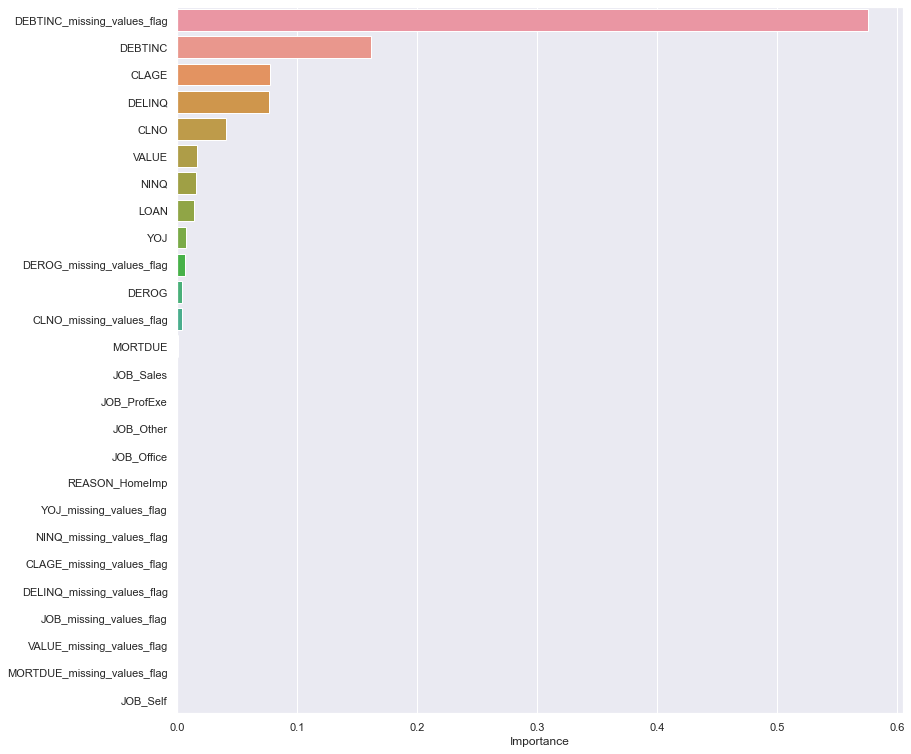

In [146]:
#Display important features
def display_imp_features(importances, columns):
    importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
    plt.figure(figsize = (13, 13))
    sns.barplot(importance_df.Importance,importance_df.index)
display_imp_features(dtree_estimator.feature_importances_, X.columns)

In [147]:
#Plot the tree
def plot_tree(dt,features):
    plt.figure(figsize = (30, 20))
    tree.plot_tree(dt, feature_names = features, filled = True, fontsize = 16, node_ids = True, class_names = True)
    plt.show()

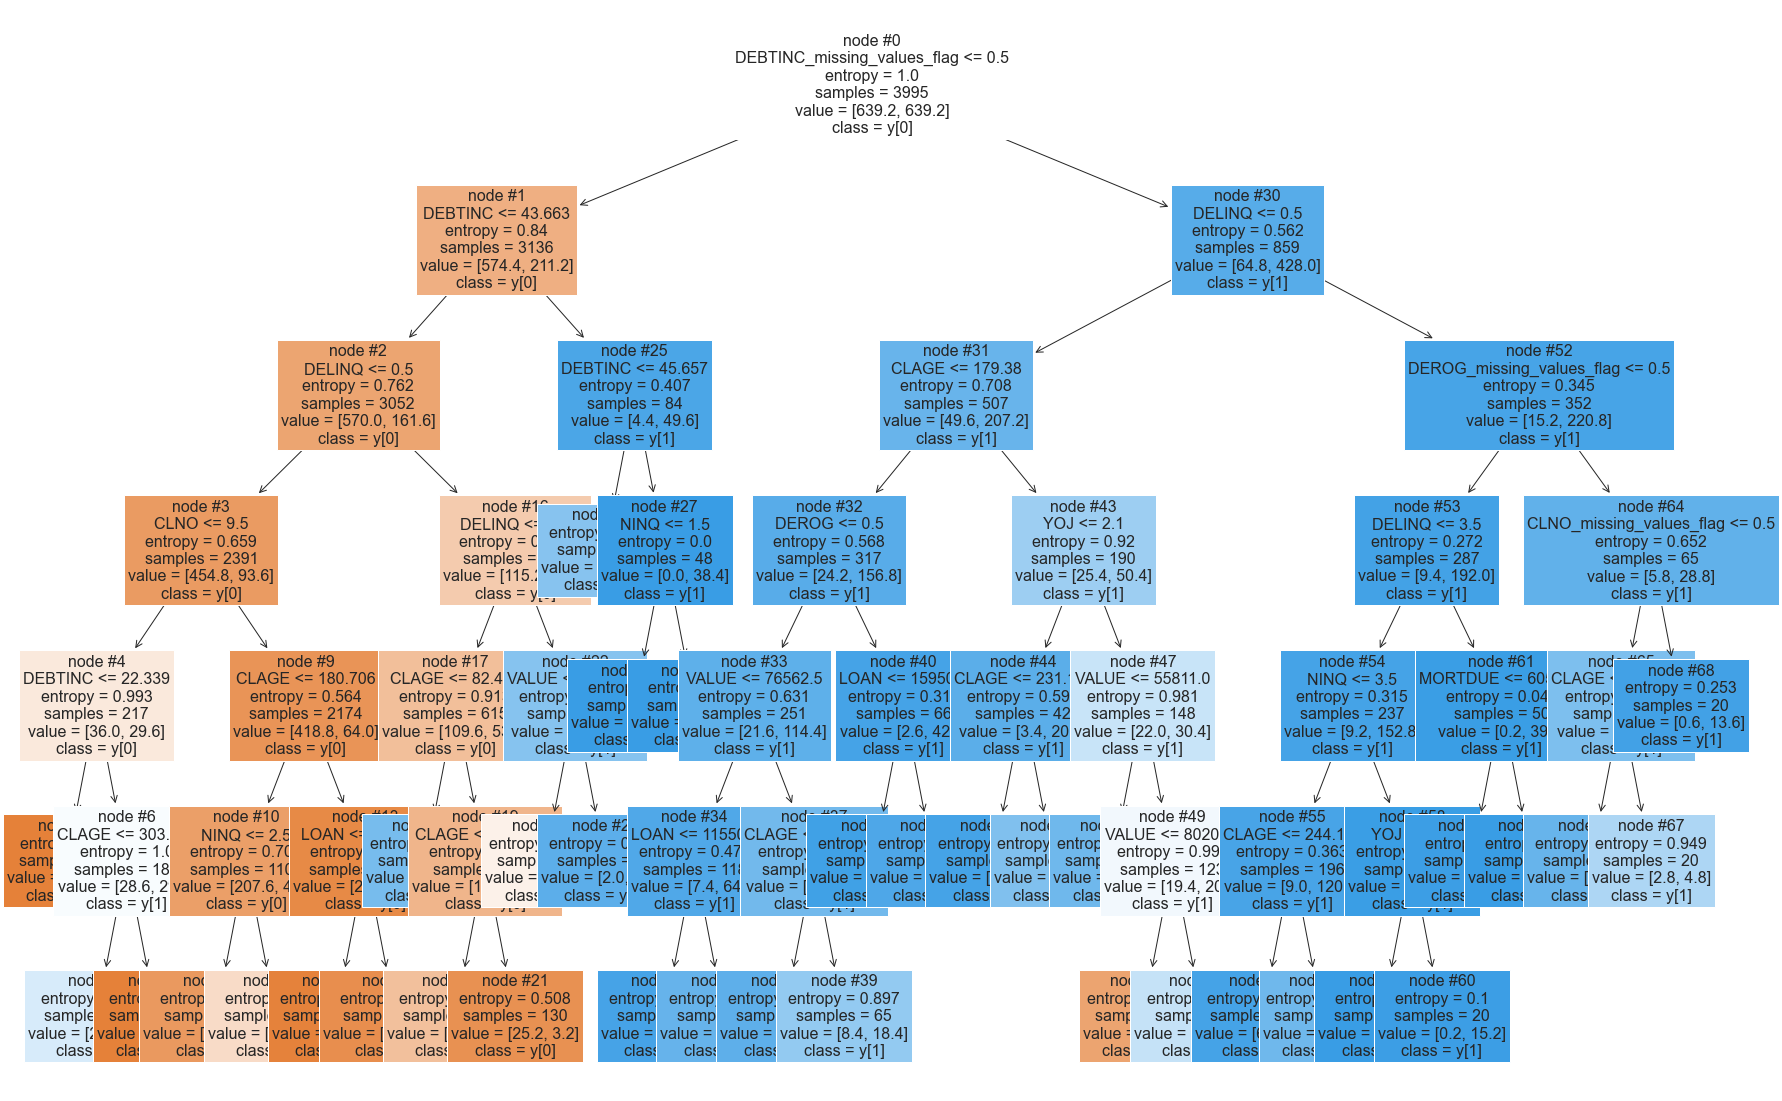

In [148]:
plot_tree(dtree_estimator,X.columns)

In [149]:
print(tree.export_text(dtree_estimator,feature_names=dtree_estimator.feature_names_in_.tolist()))

|--- DEBTINC_missing_values_flag <= 0.50
|   |--- DEBTINC <= 43.66
|   |   |--- DELINQ <= 0.50
|   |   |   |--- CLNO <= 9.50
|   |   |   |   |--- DEBTINC <= 22.34
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- DEBTINC >  22.34
|   |   |   |   |   |--- CLAGE <= 303.45
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- CLAGE >  303.45
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- CLNO >  9.50
|   |   |   |   |--- CLAGE <= 180.71
|   |   |   |   |   |--- NINQ <= 2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- NINQ >  2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- CLAGE >  180.71
|   |   |   |   |   |--- LOAN <= 15850.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- LOAN >  15850.00
|   |   |   |   |   |   |--- class: 0
|   |   |--- DELINQ >  0.50
|   |   |   |--- DELINQ <= 3.50
|   |   |   |   |--- CLAGE <= 82.47
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- CLAGE >  82.47
|   |   |   |   |   |--- 

#### Deduce the business rules apparent from the Decision Tree and write them down: _____

1. The tree identifies the DTI missing flag as a separator of good vs bad loans.
2. After which it further divides the group using the DTI ratio. If the client has DTI but the DTI > 43, the client is likely to default. Clients with DTI > 45.657 have even higher probably of defaulting.
3. After which, there are some exceptions.

**Observations ___________**
1. This tree is generalized. And recall is okay at .79.
2. The important features are: a flag indicating that DTI is missing, DTI, # of delinquent loans, age of oldest credit line, number of credit lines, # of existing credit lines, value of property, # recent loan inquiries, year in present job, # of derogatory report and missing values for derogatory report and number of credit lines.
3. The tree shows very strong importance on the missing value debtinc.


## Random Forest Classifier

**Random Forest is a bagging algorithm where the base models are Decision Trees.** Samples are taken from the training data and on each sample a decision tree makes a prediction. 

**The results from all the decision trees are combined together and the final prediction is made using voting or averaging.**

### Build a random forest classifier

In [150]:
# Defining Random forest CLassifier

rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

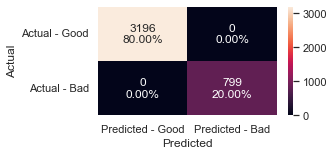

In [151]:
#Checking performance on the training data

y_pred_train_rf = rf_estimator.predict(x_train)
metrics_score(y_train, y_pred_train_rf)

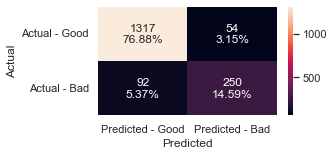

In [152]:
# Checking performance on the test data

y_pred_test_rf = rf_estimator.predict(x_test)
metrics_score(y_test, y_pred_test_rf)

In [153]:
#Compare with other models
show_metrics('Random forest',x_train,y_train,x_test,y_test, y_pred_train_rf, y_pred_test_rf, rf_estimator)
comparison_frame

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
0    Logistical Regression            0.86           0.85          0.82   
1  LG at optimal threshold            0.89           0.88          0.71   
2            Decision Tree            1.00           0.87          1.00   
3                 Tuned DT            0.85           0.83          0.82   
4            Random forest            1.00           0.91          1.00   

   Test_Recall  Train_Precision  Test_Precision  Train_F1  Test_F1  \
0         0.77             0.61            0.60      0.70     0.67   
1         0.66             0.72            0.70      0.71     0.68   
2         0.64             1.00            0.67      1.00     0.66   
3         0.78             0.59            0.55      0.69     0.65   
4         0.73             1.00            0.82      1.00     0.77   

                               Model with parameters  
0  LogisticRegression(class_weight={0: 0.2, 1: 0.8})  
1  LogisticRegression(class_weight={0: 0.2, 1: 0.8})  
2  DecisionTreeClassifier(class_weight={0: 0.2, 1...  
3  DecisionTreeClassifier(class_weight={0: 0.2, 1...  
4             RandomForestClassifier(random_state=1)

**Observations: __________**
1. The random forest is overfitting to the train data.

### Build a Random Forest model with Class Weights

In [154]:
# Defining Random Forest model with class weights class_weight={0: 0.2, 1: 0.8}
rf_estimator = RandomForestClassifier(class_weight = {0: 0.2, 1: 0.8}, random_state = 1)

# Fitting Random Forest model
rf_estimator.fit(x_train, y_train)

RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, random_state=1)

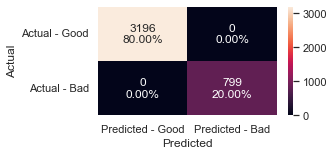

In [155]:
# Checking performance on the train data

y_pred_train_rf = rf_estimator.predict(x_train)
metrics_score(y_train, y_pred_train_rf)

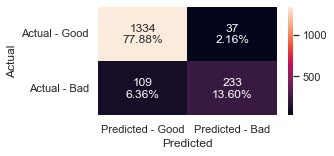

In [156]:
# Checking performance on the test data

y_pred_test_rf = rf_estimator.predict(x_test)
metrics_score(y_test, y_pred_test_rf)

In [157]:
#Compare with other models
show_metrics('RF with class weights',x_train,y_train,x_test,y_test, y_pred_train_rf, y_pred_test_rf, rf_estimator)
comparison_frame.tail()

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
1  LG at optimal threshold            0.89           0.88          0.71   
2            Decision Tree            1.00           0.87          1.00   
3                 Tuned DT            0.85           0.83          0.82   
4            Random forest            1.00           0.91          1.00   
5    RF with class weights            1.00           0.91          1.00   

   Test_Recall  Train_Precision  Test_Precision  Train_F1  Test_F1  \
1         0.66             0.72            0.70      0.71     0.68   
2         0.64             1.00            0.67      1.00     0.66   
3         0.78             0.59            0.55      0.69     0.65   
4         0.73             1.00            0.82      1.00     0.77   
5         0.68             1.00            0.86      1.00     0.76   

                               Model with parameters  
1  LogisticRegression(class_weight={0: 0.2, 1: 0.8})  
2  DecisionTreeClassifier(class_weight={0: 0.2, 1...  
3  DecisionTreeClassifier(class_weight={0: 0.2, 1...  
4             RandomForestClassifier(random_state=1)  
5  RandomForestClassifier(class_weight={0: 0.2, 1...

**Observations:____**

* The model is overfitting.
* The model favors precision over recall.
* We need to tune this model to reduce overfitting and prioritize recall.


#### Think about it:
- Can we try different weights?
- If yes, should we increase or decrease class weights for different classes? 

**Observations__**

* Balancing with class_weight= {0: .2, 1: .8} yielded similar performance with using balanced_subsample. 
* Changing the balance to class_weight= {0: .3, 1: .7}, which does not exactly match the data resulted into higher precision, but lower recall.
* Keeping the model balanced with class_weight= {0: .2, 1: .8}.

### Tune the Random Forest

* Hyperparameter tuning is tricky in the sense that **there is no direct way to calculate how a change in the hyperparameter value will reduce the loss of your model**, so we usually resort to experimentation. We'll use Grid search to perform hyperparameter tuning.
* **Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.** 
* **It is an exhaustive search** that is performed on the specific parameter values of a model.
* The parameters of the estimator/model used to apply these methods are **optimized by cross-validated grid-search** over a parameter grid.


**n_estimators**: The number of trees in the forest.

**min_samples_split**: The minimum number of samples required to split an internal node:

**min_samples_leaf**: The minimum number of samples required to be at a leaf node. 

**max_features{“auto”, “sqrt”, “log2”, 'None'}**: The number of features to consider when looking for the best split.

- If “auto”, then max_features=sqrt(n_features).

- If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).

- If “log2”, then max_features=log2(n_features).

- If None, then max_features=n_features.

You can learn more about Random Forest Hyperparameters from the link given below and try to tune them

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

**Warning:** This may take a long time depending on the parameters you tune. 

In [158]:
%%time
# Choose the type of classifier. 
rf_estimator_tuned = RandomForestClassifier(random_state = 1, class_weight= {0: .2, 1: .8})


# Grid of parameters to choose from
params_rf = {"n_estimators": [100, 150, 200],
    "min_samples_leaf": [15, 20, 30],
    "max_depth": np.arange(5,8),
    "max_features": ['auto', 0.5, 0.7]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, params_rf, scoring = scorer, cv = 10)

#fit the GridSearch on train dataset
grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_estimator_tuned.fit(x_train, y_train)

CPU times: user 21min 24s, sys: 24.1 s, total: 21min 48s
Wall time: 24min 19s


RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=7,
                       min_samples_leaf=20, n_estimators=200, random_state=1)

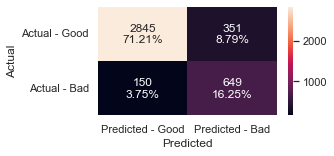

In [159]:
# Checking performance on the training data

y_pred_train_rf_tuned = rf_estimator_tuned.predict(x_train)
metrics_score(y_train, y_pred_train_rf_tuned)

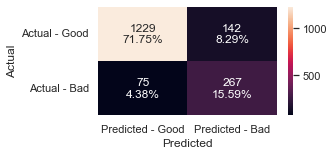

In [160]:
# Checking performace on test dataset

y_pred_test_rf_tuned = rf_estimator_tuned.predict(x_test)
metrics_score(y_test, y_pred_test_rf_tuned)

In [161]:
#Compare with previous models
show_metrics('Tuned Random Forest',x_train,y_train,x_test,y_test, y_pred_train_rf_tuned, y_pred_test_rf_tuned, rf_estimator_tuned)
comparison_frame.tail()

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
2          Decision Tree            1.00           0.87          1.00   
3               Tuned DT            0.85           0.83          0.82   
4          Random forest            1.00           0.91          1.00   
5  RF with class weights            1.00           0.91          1.00   
6    Tuned Random Forest            0.87           0.87          0.81   

   Test_Recall  Train_Precision  Test_Precision  Train_F1  Test_F1  \
2         0.64             1.00            0.67      1.00     0.66   
3         0.78             0.59            0.55      0.69     0.65   
4         0.73             1.00            0.82      1.00     0.77   
5         0.68             1.00            0.86      1.00     0.76   
6         0.78             0.65            0.65      0.72     0.71   

                               Model with parameters  
2  DecisionTreeClassifier(class_weight={0: 0.2, 1...  
3  DecisionTreeClassifier(class_weight={0: 0.2, 1...  
4             RandomForestClassifier(random_state=1)  
5  RandomForestClassifier(class_weight={0: 0.2, 1...  
6  RandomForestClassifier(class_weight={0: 0.2, 1...

**Insights: _____**

* The decision tree and random forest all have to be tuned to avoid overfitting. Mostly they are pruned by limiting the max dept and increasing minimum sample leaves
* The tuned random forest is generalized and have a good accuracy, recall and precision. This is a viable model.


#### Plot the Feature importance of the tuned Random Forest

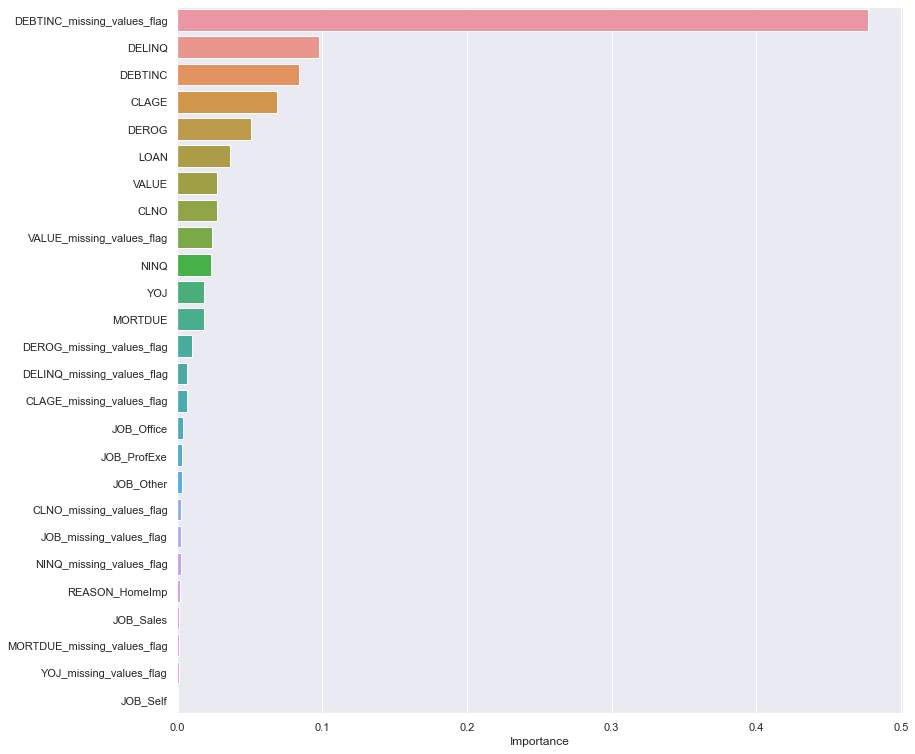

In [162]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

display_imp_features(rf_estimator_tuned.feature_importances_, X.columns)

### Tune the random forest with RandomSearchCV using the same parameters

In [163]:
from sklearn.model_selection import RandomizedSearchCV

In [164]:
%%time
# Choose the type of classifier. 
rf_estimator_tuned = RandomForestClassifier(class_weight = {0: 0.2, 1: 0.8}, random_state = 1)

# Grid of parameters to choose from
params_rf = {"n_estimators": [100, 150, 200],
    "min_samples_leaf": [15, 20, 30],
    "max_depth": np.arange(5,8),
    "max_features": ['auto', 0.5, 0.7],
             }
            
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
rs_obj = RandomizedSearchCV(rf_estimator_tuned, params_rf, scoring = scorer, cv = 10, n_jobs = 4)

#fit the GridSearch on train dataset
rs_obj = rs_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator_tuned = rs_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_estimator_tuned.fit(x_train, y_train)

CPU times: user 3.38 s, sys: 279 ms, total: 3.66 s
Wall time: 2min 6s


RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=7,
                       min_samples_leaf=30, n_estimators=200, random_state=1)

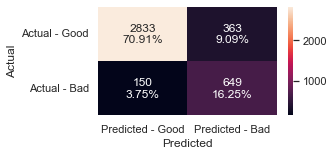

In [165]:
# Checking performance on the training data
y_pred_train_rf_tuned = rf_estimator_tuned.predict(x_train)
metrics_score(y_train, y_pred_train_rf_tuned)

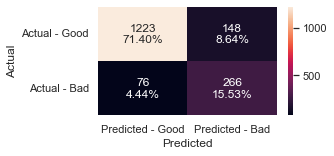

In [166]:
# Checking performace on test dataset

y_pred_test_rf_tuned = rf_estimator_tuned.predict(x_test)
metrics_score(y_test, y_pred_test_rf_tuned)

In [167]:
# Compare performance with previous models
show_metrics('RF Tuned with RandomSearchCV',x_train,y_train,x_test,y_test, y_pred_train_rf_tuned, y_pred_test_rf_tuned, rf_estimator_tuned)
comparison_frame.tail()

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
3                      Tuned DT            0.85           0.83          0.82   
4                 Random forest            1.00           0.91          1.00   
5         RF with class weights            1.00           0.91          1.00   
6           Tuned Random Forest            0.87           0.87          0.81   
7  RF Tuned with RandomSearchCV            0.87           0.87          0.81   

   Test_Recall  Train_Precision  Test_Precision  Train_F1  Test_F1  \
3         0.78             0.59            0.55      0.69     0.65   
4         0.73             1.00            0.82      1.00     0.77   
5         0.68             1.00            0.86      1.00     0.76   
6         0.78             0.65            0.65      0.72     0.71   
7         0.78             0.64            0.64      0.72     0.70   

                               Model with parameters  
3  DecisionTreeClassifier(class_weight={0: 0.2, 1...  
4             RandomForestClassifier(random_state=1)  
5  RandomForestClassifier(class_weight={0: 0.2, 1...  
6  RandomForestClassifier(class_weight={0: 0.2, 1...  
7  RandomForestClassifier(class_weight={0: 0.2, 1...

**Observations__**

Using the random search yields similar and even better result as the grid search. Using random search onwards.

## Boosting Models

In [168]:
# Installing the xgboost library using the 'pip' command.
#!pip install xgboost

In [169]:
# Importing the AdaBoostClassifier and GradientBoostingClassifier [Boosting]
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# Importing the XGBClassifier from the xgboost library
from xgboost import XGBClassifier

### AdaBoost

In [170]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3995 entries, 5408 to 836
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LOAN                         3995 non-null   float64
 1   MORTDUE                      3995 non-null   float64
 2   VALUE                        3995 non-null   float64
 3   YOJ                          3995 non-null   float64
 4   DEROG                        3995 non-null   int64  
 5   DELINQ                       3995 non-null   int64  
 6   CLAGE                        3995 non-null   float64
 7   NINQ                         3995 non-null   int64  
 8   CLNO                         3995 non-null   float64
 9   DEBTINC                      3995 non-null   float64
 10  MORTDUE_missing_values_flag  3995 non-null   bool   
 11  VALUE_missing_values_flag    3995 non-null   bool   
 12  JOB_missing_values_flag      3995 non-null   bool   
 13  YOJ_missing_valu

In [171]:
# Adaboost Classifier
adaboost_model = AdaBoostClassifier(random_state = 1)

# Fitting the model
adaboost_model.fit(x_train, y_train)

# Check performance on train and test data
pred_train = adaboost_model.predict(x_train)
pred_test = adaboost_model.predict(x_test)

In [172]:
show_metrics('adaboost',x_train,y_train,x_test,y_test, pred_train, pred_test, adaboost_model)
comparison_frame.tail()

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
4                 Random forest            1.00           0.91          1.00   
5         RF with class weights            1.00           0.91          1.00   
6           Tuned Random Forest            0.87           0.87          0.81   
7  RF Tuned with RandomSearchCV            0.87           0.87          0.81   
8                      adaboost            0.91           0.90          0.69   

   Test_Recall  Train_Precision  Test_Precision  Train_F1  Test_F1  \
4         0.73             1.00            0.82      1.00     0.77   
5         0.68             1.00            0.86      1.00     0.76   
6         0.78             0.65            0.65      0.72     0.71   
7         0.78             0.64            0.64      0.72     0.70   
8         0.65             0.83            0.81      0.75     0.72   

                               Model with parameters  
4             RandomForestClassifier(random_state=1)  
5  RandomForestClassifier(class_weight={0: 0.2, 1...  
6  RandomForestClassifier(class_weight={0: 0.2, 1...  
7  RandomForestClassifier(class_weight={0: 0.2, 1...  
8                 AdaBoostClassifier(random_state=1)

### Gradient Boost

In [173]:
# Gradient Boost Classifier
gbc = GradientBoostingClassifier(random_state = 1)

# Fitting the model
gbc.fit(x_train, y_train)

# Check performance on train and test data
pred_train = gbc.predict(x_train)
pred_test = gbc.predict(x_test)

In [174]:
show_metrics('Gradient Boost',x_train,y_train,x_test,y_test, pred_train, pred_test, gbc)
comparison_frame.tail()

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
5         RF with class weights            1.00           0.91          1.00   
6           Tuned Random Forest            0.87           0.87          0.81   
7  RF Tuned with RandomSearchCV            0.87           0.87          0.81   
8                      adaboost            0.91           0.90          0.69   
9                Gradient Boost            0.92           0.92          0.72   

   Test_Recall  Train_Precision  Test_Precision  Train_F1  Test_F1  \
5         0.68             1.00            0.86      1.00     0.76   
6         0.78             0.65            0.65      0.72     0.71   
7         0.78             0.64            0.64      0.72     0.70   
8         0.65             0.83            0.81      0.75     0.72   
9         0.69             0.88            0.87      0.79     0.77   

                               Model with parameters  
5  RandomForestClassifier(class_weight={0: 0.2, 1...  
6  RandomForestClassifier(class_weight={0: 0.2, 1...  
7  RandomForestClassifier(class_weight={0: 0.2, 1...  
8                 AdaBoostClassifier(random_state=1)  
9         GradientBoostingClassifier(random_state=1)

### XGBoost

In [175]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3995 entries, 5408 to 836
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LOAN                         3995 non-null   float64
 1   MORTDUE                      3995 non-null   float64
 2   VALUE                        3995 non-null   float64
 3   YOJ                          3995 non-null   float64
 4   DEROG                        3995 non-null   int64  
 5   DELINQ                       3995 non-null   int64  
 6   CLAGE                        3995 non-null   float64
 7   NINQ                         3995 non-null   int64  
 8   CLNO                         3995 non-null   float64
 9   DEBTINC                      3995 non-null   float64
 10  MORTDUE_missing_values_flag  3995 non-null   bool   
 11  VALUE_missing_values_flag    3995 non-null   bool   
 12  JOB_missing_values_flag      3995 non-null   bool   
 13  YOJ_missing_valu

In [176]:
# XGBoost Classifier
xgb = XGBClassifier(random_state = 1, eval_metric = 'logloss')

# Fitting the model
xgb.fit(x_train,y_train)

# Check performance on train and test data
pred_train = xgb.predict(x_train)
pred_test = xgb.predict(x_test)

In [177]:
show_metrics('XGBoost',x_train,y_train,x_test,y_test, pred_train, pred_test, xgb)
comparison_frame.tail()

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
6            Tuned Random Forest            0.87           0.87          0.81   
7   RF Tuned with RandomSearchCV            0.87           0.87          0.81   
8                       adaboost            0.91           0.90          0.69   
9                 Gradient Boost            0.92           0.92          0.72   
10                       XGBoost            1.00           0.93          1.00   

    Test_Recall  Train_Precision  Test_Precision  Train_F1  Test_F1  \
6          0.78             0.65            0.65      0.72     0.71   
7          0.78             0.64            0.64      0.72     0.70   
8          0.65             0.83            0.81      0.75     0.72   
9          0.69             0.88            0.87      0.79     0.77   
10         0.75             1.00            0.89      1.00     0.81   

                                Model with parameters  
6   RandomForestClassifier(class_weight={0: 0.2, 1...  
7   RandomForestClassifier(class_weight={0: 0.2, 1...  
8                  AdaBoostClassifier(random_state=1)  
9          GradientBoostingClassifier(random_state=1)  
10  XGBClassifier(base_score=0.5, booster='gbtree'...

### Try to reduce XGBoost overfitting with earlystopping

In [178]:
#Reduce overfitting by earlystopping
xgb.fit(x_train, y_train, 
            eval_set=[(x_train, y_train), (x_test, y_test)], 
            early_stopping_rounds=10) 

[0]	validation_0-logloss:0.51675	validation_1-logloss:0.52087
[1]	validation_0-logloss:0.41800	validation_1-logloss:0.42878
[2]	validation_0-logloss:0.35772	validation_1-logloss:0.37149
[3]	validation_0-logloss:0.31369	validation_1-logloss:0.33440
[4]	validation_0-logloss:0.28582	validation_1-logloss:0.30964
[5]	validation_0-logloss:0.26316	validation_1-logloss:0.29141
[6]	validation_0-logloss:0.24578	validation_1-logloss:0.28029
[7]	validation_0-logloss:0.23157	validation_1-logloss:0.26977
[8]	validation_0-logloss:0.21948	validation_1-logloss:0.26317
[9]	validation_0-logloss:0.21016	validation_1-logloss:0.25818
[10]	validation_0-logloss:0.19637	validation_1-logloss:0.25006
[11]	validation_0-logloss:0.18878	validation_1-logloss:0.24654
[12]	validation_0-logloss:0.18203	validation_1-logloss:0.24275
[13]	validation_0-logloss:0.17734	validation_1-logloss:0.23985
[14]	validation_0-logloss:0.16866	validation_1-logloss:0.23525
[15]	validation_0-logloss:0.16501	validation_1-logloss:0.23282
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1, ...)

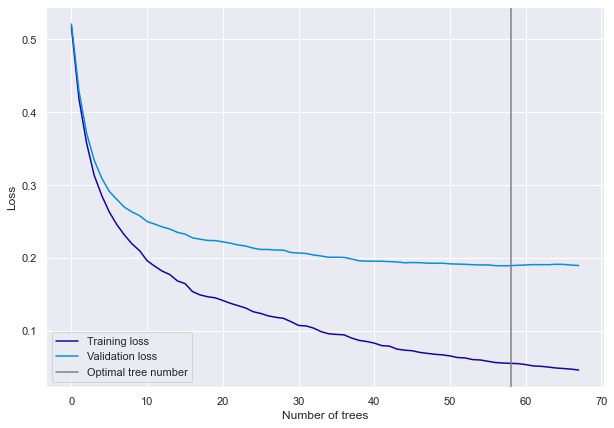

In [179]:
results = xgb.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Validation loss")
plt.axvline(xgb.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [180]:
xgb.best_ntree_limit

58

In [181]:
# Check performance on train and test data
pred_train = xgb.predict(x_train)
pred_test = xgb.predict(x_test)

In [182]:
show_metrics('XGBoost with early stopping',x_train,y_train,x_test,y_test, pred_train, pred_test, xgb)
comparison_frame.tail()

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
7   RF Tuned with RandomSearchCV            0.87           0.87          0.81   
8                       adaboost            0.91           0.90          0.69   
9                 Gradient Boost            0.92           0.92          0.72   
10                       XGBoost            1.00           0.93          1.00   
11   XGBoost with early stopping            0.99           0.93          0.96   

    Test_Recall  Train_Precision  Test_Precision  Train_F1  Test_F1  \
7          0.78             0.64            0.64      0.72     0.70   
8          0.65             0.83            0.81      0.75     0.72   
9          0.69             0.88            0.87      0.79     0.77   
10         0.75             1.00            0.89      1.00     0.81   
11         0.74             1.00            0.89      0.98     0.81   

                                Model with parameters  
7   RandomForestClassifier(class_weight={0: 0.2, 1...  
8                  AdaBoostClassifier(random_state=1)  
9          GradientBoostingClassifier(random_state=1)  
10  XGBClassifier(base_score=0.5, booster='gbtree'...  
11  XGBClassifier(base_score=0.5, booster='gbtree'...

### Tune XGB with RandomSearchCV to generalize results since early stopping is not good enough


In [183]:
%%time

# Choose the type of classifier. 
classifier = XGBClassifier(random_state = 1, eval_metric='logloss')

# Grid of parameters to choose from
params_rf = {"n_estimators": [30, 40, 50],
    "max_depth": np.arange(3,4,5),
    "learning_rate": [0.2, 0.3], # default 0.1 
    "subsample": [0.4, 0.6, 0.8],
    "min_child_weight":[0,1,2,3,4,5],
    "gamma":[0.4, 0.6, 0.8, 0.9, 1]
             }
            
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the random search
rs_obj = RandomizedSearchCV(classifier, params_rf, scoring = scorer, cv = 10, n_jobs = 4, verbose=1)

#fit the RandomSearch on train dataset
rs_obj = rs_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = rs_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
CPU times: user 2.13 s, sys: 127 ms, total: 2.26 s
Wall time: 24.5 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0.9, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=0, missing=nan,
              monotone_constraints='()', n_estimators=40, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=1, ...)

In [184]:
# Check performance on train and test data
pred_train = xgb_tuned.predict(x_train)
pred_test = xgb_tuned.predict(x_test)

In [185]:
show_metrics('Tuned XGBoost',x_train,y_train,x_test,y_test, pred_train, pred_test, xgb_tuned)

In [186]:
comparison_frame.tail()

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
8                      adaboost            0.91           0.90          0.69   
9                Gradient Boost            0.92           0.92          0.72   
10                      XGBoost            1.00           0.93          1.00   
11  XGBoost with early stopping            0.99           0.93          0.96   
12                Tuned XGBoost            0.92           0.92          0.72   

    Test_Recall  Train_Precision  Test_Precision  Train_F1  Test_F1  \
8          0.65             0.83            0.81      0.75     0.72   
9          0.69             0.88            0.87      0.79     0.77   
10         0.75             1.00            0.89      1.00     0.81   
11         0.74             1.00            0.89      0.98     0.81   
12         0.68             0.87            0.88      0.79     0.76   

                                Model with parameters  
8                  AdaBoostClassifier(random_state=1)  
9          GradientBoostingClassifier(random_state=1)  
10  XGBClassifier(base_score=0.5, booster='gbtree'...  
11  XGBClassifier(base_score=0.5, booster='gbtree'...  
12  XGBClassifier(base_score=0.5, booster='gbtree'...

### Try XGBoost with undersampling to see effect on generalization and recall

In [187]:
#!pip install imbalanced-learn

In [188]:
from imblearn.under_sampling import RandomUnderSampler

In [189]:
rus = RandomUnderSampler(random_state = 1)
X_train_un, y_train_un = rus.fit_resample(x_train, y_train)

In [190]:
print("Before Under Sampling, counts of label 'Yes': {}".format(sum(y_train==1)))
print("Before Under Sampling, counts of label 'No': {} \n".format(sum(y_train==0)))

print("After Under Sampling, counts of label 'Yes': {}".format(sum(y_train_un==1)))
print("After Under Sampling, counts of label 'No': {} \n".format(sum(y_train_un==0)))

print('After Under Sampling, the shape of train_X: {}'.format(X_train_un.shape))
print('After Under Sampling, the shape of train_y: {} \n'.format(y_train_un.shape))

Before Under Sampling, counts of label 'Yes': 799
Before Under Sampling, counts of label 'No': 3196 

After Under Sampling, counts of label 'Yes': 799
After Under Sampling, counts of label 'No': 799 

After Under Sampling, the shape of train_X: (1598, 26)
After Under Sampling, the shape of train_y: (1598,) 



In [191]:
#Run RandomSearch using the undersampled data set
rs_obj = rs_obj.fit(X_train_un, y_train_un)

# Set the clf to the best combination of parameters
xgb_tuned = rs_obj.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [192]:
xgb_tuned.fit(X_train_un, y_train_un)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=0, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=1, ...)

In [193]:
# Check performance on train and test data
pred_train = xgb_tuned.predict(X_train_un)
pred_test = xgb_tuned.predict(x_test)

In [194]:
show_metrics('XGBoost with undersampling',X_train_un,y_train_un,x_test,y_test, pred_train, pred_test, xgb_tuned)

In [195]:
comparison_frame.tail()

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
9                Gradient Boost            0.92           0.92          0.72   
10                      XGBoost            1.00           0.93          1.00   
11  XGBoost with early stopping            0.99           0.93          0.96   
12                Tuned XGBoost            0.92           0.92          0.72   
13   XGBoost with undersampling            0.91           0.88          0.90   

    Test_Recall  Train_Precision  Test_Precision  Train_F1  Test_F1  \
9          0.69             0.88            0.87      0.79     0.77   
10         0.75             1.00            0.89      1.00     0.81   
11         0.74             1.00            0.89      0.98     0.81   
12         0.68             0.87            0.88      0.79     0.76   
13         0.85             0.93            0.66      0.91     0.74   

                                Model with parameters  
9          GradientBoostingClassifier(random_state=1)  
10  XGBClassifier(base_score=0.5, booster='gbtree'...  
11  XGBClassifier(base_score=0.5, booster='gbtree'...  
12  XGBClassifier(base_score=0.5, booster='gbtree'...  
13  XGBClassifier(base_score=0.5, booster='gbtree'...

**Observations__**
Undersampling increased recall but did not increase precision enough and still overfitting on train data.

### Tune XGBoost with scale_pos_weight

In [196]:
scale_pos=[]
scale_pos.append(sum(y_train==0)/sum(y_train==1))
scale_pos.append(np.sqrt(sum(y_train==0)/sum(y_train==1)))
print(scale_pos)

[4.0, 2.0]


In [197]:
#Add scale_pos_weight to random search and reduce estimators to increase recall and reduce overfitting

In [198]:
# Choose the type of classifier. 
classifier = XGBClassifier(random_state = 1, eval_metric='logloss')

# Grid of parameters to choose from
params_rf = {"n_estimators": [30, 40, 50],
    "max_depth": np.arange(3,4,5),
    "learning_rate": [0.2, 0.3], # default 0.1 
    "subsample": [0.4, 0.6, 0.8],
    "min_child_weight":[0,1,2,3,4,5],
    "gamma":[0.4, 0.6, 0.8, 0.9, 1],
    "scale_pos_weight":scale_pos
             }
            
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the random search
rs_obj = RandomizedSearchCV(classifier, params_rf, scoring = scorer, cv = 10, n_jobs = 4, verbose=1)

#fit the RandomSearch on train dataset
rs_obj = rs_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = rs_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=0, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=1, ...)

In [199]:
xgb_tuned.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': 1,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.3,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 3,
 'max_leaves': 0,
 'min_child_weight': 0,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 50,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 1,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 4.0,
 'subsample': 0.8,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [200]:
# Check performance on train and test data
pred_train = xgb_tuned.predict(x_train)
pred_test = xgb_tuned.predict(x_test)

In [201]:
# Show and compare metrics
show_metrics('Tuned XGBoost with scale_pos_weight',x_train,y_train,x_test,y_test, pred_train, pred_test, xgb_tuned)

In [202]:
comparison_frame.tail()

Model  Train_Accuracy  Test_Accuracy  \
10                              XGBoost            1.00           0.93   
11          XGBoost with early stopping            0.99           0.93   
12                        Tuned XGBoost            0.92           0.92   
13           XGBoost with undersampling            0.91           0.88   
14  Tuned XGBoost with scale_pos_weight            0.92           0.90   

    Train_Recall  Test_Recall  Train_Precision  Test_Precision  Train_F1  \
10          1.00         0.75             1.00            0.89      1.00   
11          0.96         0.74             1.00            0.89      0.98   
12          0.72         0.68             0.87            0.88      0.79   
13          0.90         0.85             0.93            0.66      0.91   
14          0.90         0.83             0.75            0.72      0.82   

    Test_F1                              Model with parameters  
10     0.81  XGBClassifier(base_score=0.5, booster='gbtree'...  
11     0.81  XGBClassifier(base_score=0.5, booster='gbtree'...  
12     0.76  XGBClassifier(base_score=0.5, booster='gbtree'...  
13     0.74  XGBClassifier(base_score=0.5, booster='gbtree'...  
14     0.77  XGBClassifier(base_score=0.5, booster='gbtree'...

# Explain the best classifier

## Display feature importance

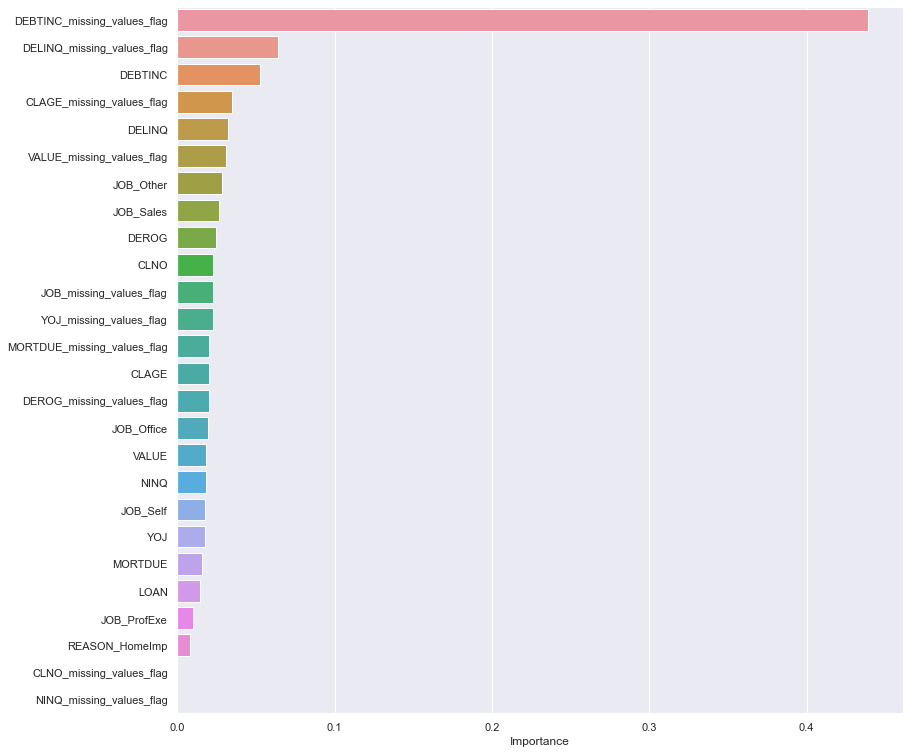

In [203]:
display_imp_features(xgb_tuned.feature_importances_, x_train.columns)

## Use SHAP to explain how the features impact outcomes

In [204]:
import shap
explainer = shap.TreeExplainer(xgb_tuned)

In [205]:
shap_values = explainer.shap_values(x_test)

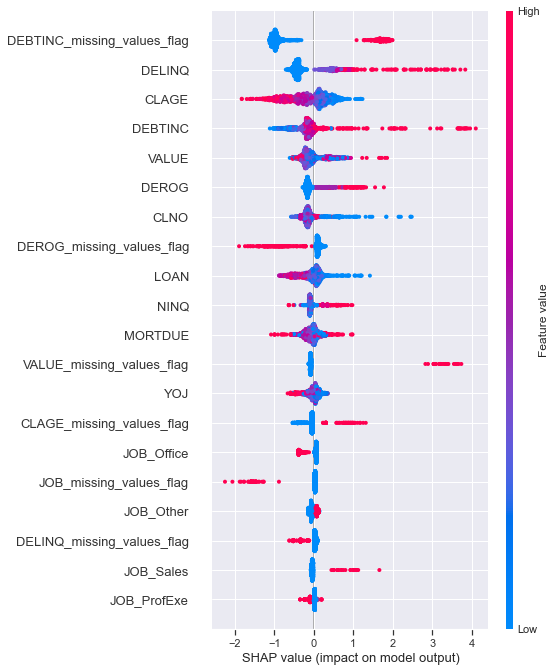

In [206]:
shap.summary_plot(shap_values,x_test)

## Use SHAP to explain an instance of the loan application

In [207]:
#Display for a specific row 
row=1
data_for_prediction=x_test.iloc[row:row+1,:] #df
data_for_prediction_array = data_for_prediction.values.reshape(1, -1) #array
print(xgb_tuned.predict_proba(data_for_prediction_array))
shap_values = explainer.shap_values(data_for_prediction_array)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)


[[0.03030854 0.96969146]]


** Observations:__**
1. Boosters were also tried. However, the models are not generalized. Perhaps the data needs to be cleaner or more targeted tuning can be explored.
2. It took different approaches to tune XGBoost, after pruning and balancing the data, a desired recall, precision and accuracy balance has been achieved. 
3. The XGBoost model is explained with SHAP to satisfy the requirement of interpretability.

# Try modeling without the flags 

Since the above algorithms all have the missing the DTI ratio as the primary predictor, the DT, random forest and XGBoost are executed again to see how they perform assuming the data were filled vs imputed.

## Prepare data set

In [208]:
#Use data set where outliers were not treated
olX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5708 entries, 0 to 5707
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LOAN                         5708 non-null   float64
 1   MORTDUE                      5708 non-null   float64
 2   VALUE                        5708 non-null   float64
 3   YOJ                          5708 non-null   float64
 4   DEROG                        5708 non-null   int64  
 5   DELINQ                       5708 non-null   int64  
 6   CLAGE                        5708 non-null   float64
 7   NINQ                         5708 non-null   int64  
 8   CLNO                         5708 non-null   float64
 9   DEBTINC                      5708 non-null   float64
 10  MORTDUE_missing_values_flag  5708 non-null   bool   
 11  VALUE_missing_values_flag    5708 non-null   bool   
 12  JOB_missing_values_flag      5708 non-null   bool   
 13  YOJ_missing_values

In [209]:
#Use the data used for decision trees, outliers not treated
olX.describe(include=['float64']).T

count      mean      std     min      25%      50%       75%  \
LOAN    5708.00  18722.32 11327.21 1100.00 11100.00 16400.00  23500.00   
MORTDUE 5708.00  73017.37 43476.86 2063.00 46406.00 64371.40  90001.50   
VALUE   5708.00 101575.05 57737.55 8000.00 65777.00 89020.50 119202.25   
YOJ     5708.00      8.92     7.34    0.00     3.00     7.00     13.00   
CLAGE   5708.00    178.14    82.51    0.00   115.81   171.49    227.36   
CLNO    5708.00     21.32    10.03    0.00    15.00    20.00     26.00   
DEBTINC 5708.00     33.65     7.69    0.52    29.32    34.27     38.51   

              max  
LOAN     89900.00  
MORTDUE 399550.00  
VALUE   855909.00  
YOJ         41.00  
CLAGE      649.75  
CLNO        71.00  
DEBTINC    203.31

In [210]:
print(cols_missing_flags)

['MORTDUE_missing_values_flag', 'VALUE_missing_values_flag', 'JOB_missing_values_flag', 'YOJ_missing_values_flag', 'DEROG_missing_values_flag', 'DELINQ_missing_values_flag', 'CLAGE_missing_values_flag', 'NINQ_missing_values_flag', 'CLNO_missing_values_flag', 'DEBTINC_missing_values_flag']


In [211]:
#Drop missing values flag
X1=olX.drop(columns=cols_missing_flags)

In [212]:
X1.columns

Index(['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
       'CLNO', 'DEBTINC', 'REASON_HomeImp', 'JOB_Office', 'JOB_Other',
       'JOB_ProfExe', 'JOB_Sales', 'JOB_Self'],
      dtype='object')

In [213]:
X1.shape

(5708, 16)

In [214]:
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(X1, olY, test_size = 0.3, random_state = 1, stratify = Y)

## Try tuned decision tree classifier

In [215]:
%%time
# Choose the type of classifier. 
dtree_estimator = DecisionTreeClassifier(class_weight = {0: 0.2, 1: 0.8}, random_state = 1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(3, 7), 
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [20, 30, 40]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
gridCV = GridSearchCV(dtree_estimator, parameters, scoring = scorer, cv = 10)

# Fit the GridSearch on train dataset
gridCV = gridCV.fit(x_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = gridCV.best_estimator_

dtree_estimator.fit(x_train, y_train)

CPU times: user 8.34 s, sys: 234 ms, total: 8.58 s
Wall time: 12.1 s


DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, criterion='entropy',
                       max_depth=5, min_samples_leaf=30, random_state=1)

In [216]:
# Checking performance on the training data based on the tuned model
# Remove _________ and complete the code

y_train_pred_dt = dtree_estimator.predict(x_train)
y_test_pred_dt = dtree_estimator.predict(x_test)

In [217]:
show_metrics('Tuned DT without flags',x_train,y_train,x_test,y_test, y_train_pred_dt, y_test_pred_dt, dtree_estimator)
comparison_frame.tail()

Model  Train_Accuracy  Test_Accuracy  \
11          XGBoost with early stopping            0.99           0.93   
12                        Tuned XGBoost            0.92           0.92   
13           XGBoost with undersampling            0.91           0.88   
14  Tuned XGBoost with scale_pos_weight            0.92           0.90   
15               Tuned DT without flags            0.73           0.73   

    Train_Recall  Test_Recall  Train_Precision  Test_Precision  Train_F1  \
11          0.96         0.74             1.00            0.89      0.98   
12          0.72         0.68             0.87            0.88      0.79   
13          0.90         0.85             0.93            0.66      0.91   
14          0.90         0.83             0.75            0.72      0.82   
15          0.71         0.70             0.40            0.39      0.51   

    Test_F1                              Model with parameters  
11     0.81  XGBClassifier(base_score=0.5, booster='gbtree'...  
12     0.76  XGBClassifier(base_score=0.5, booster='gbtree'...  
13     0.74  XGBClassifier(base_score=0.5, booster='gbtree'...  
14     0.77  XGBClassifier(base_score=0.5, booster='gbtree'...  
15     0.50  DecisionTreeClassifier(class_weight={0: 0.2, 1...

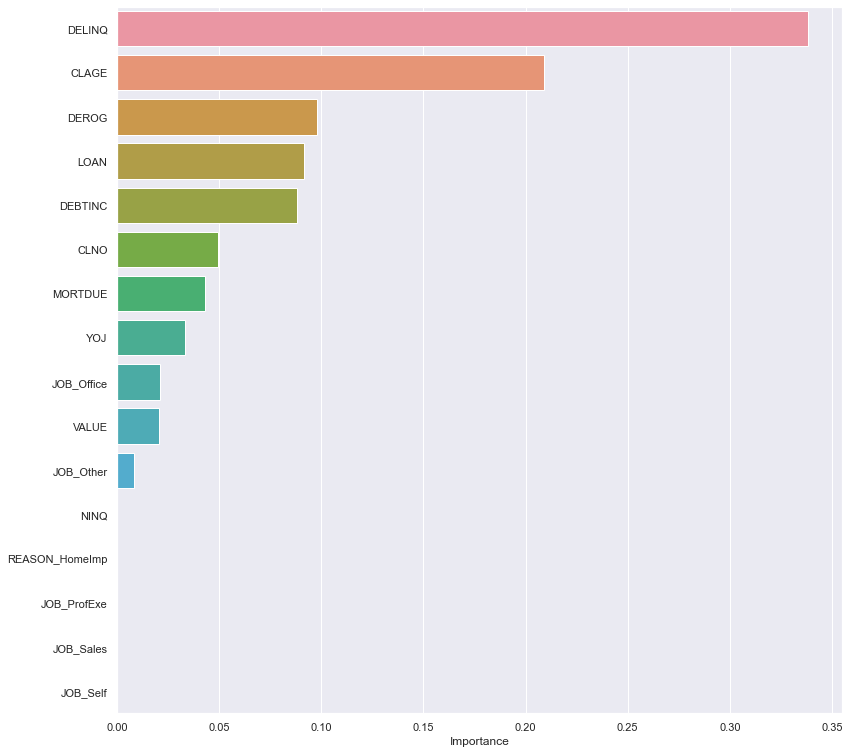

In [218]:
display_imp_features(dtree_estimator.feature_importances_, X1.columns)

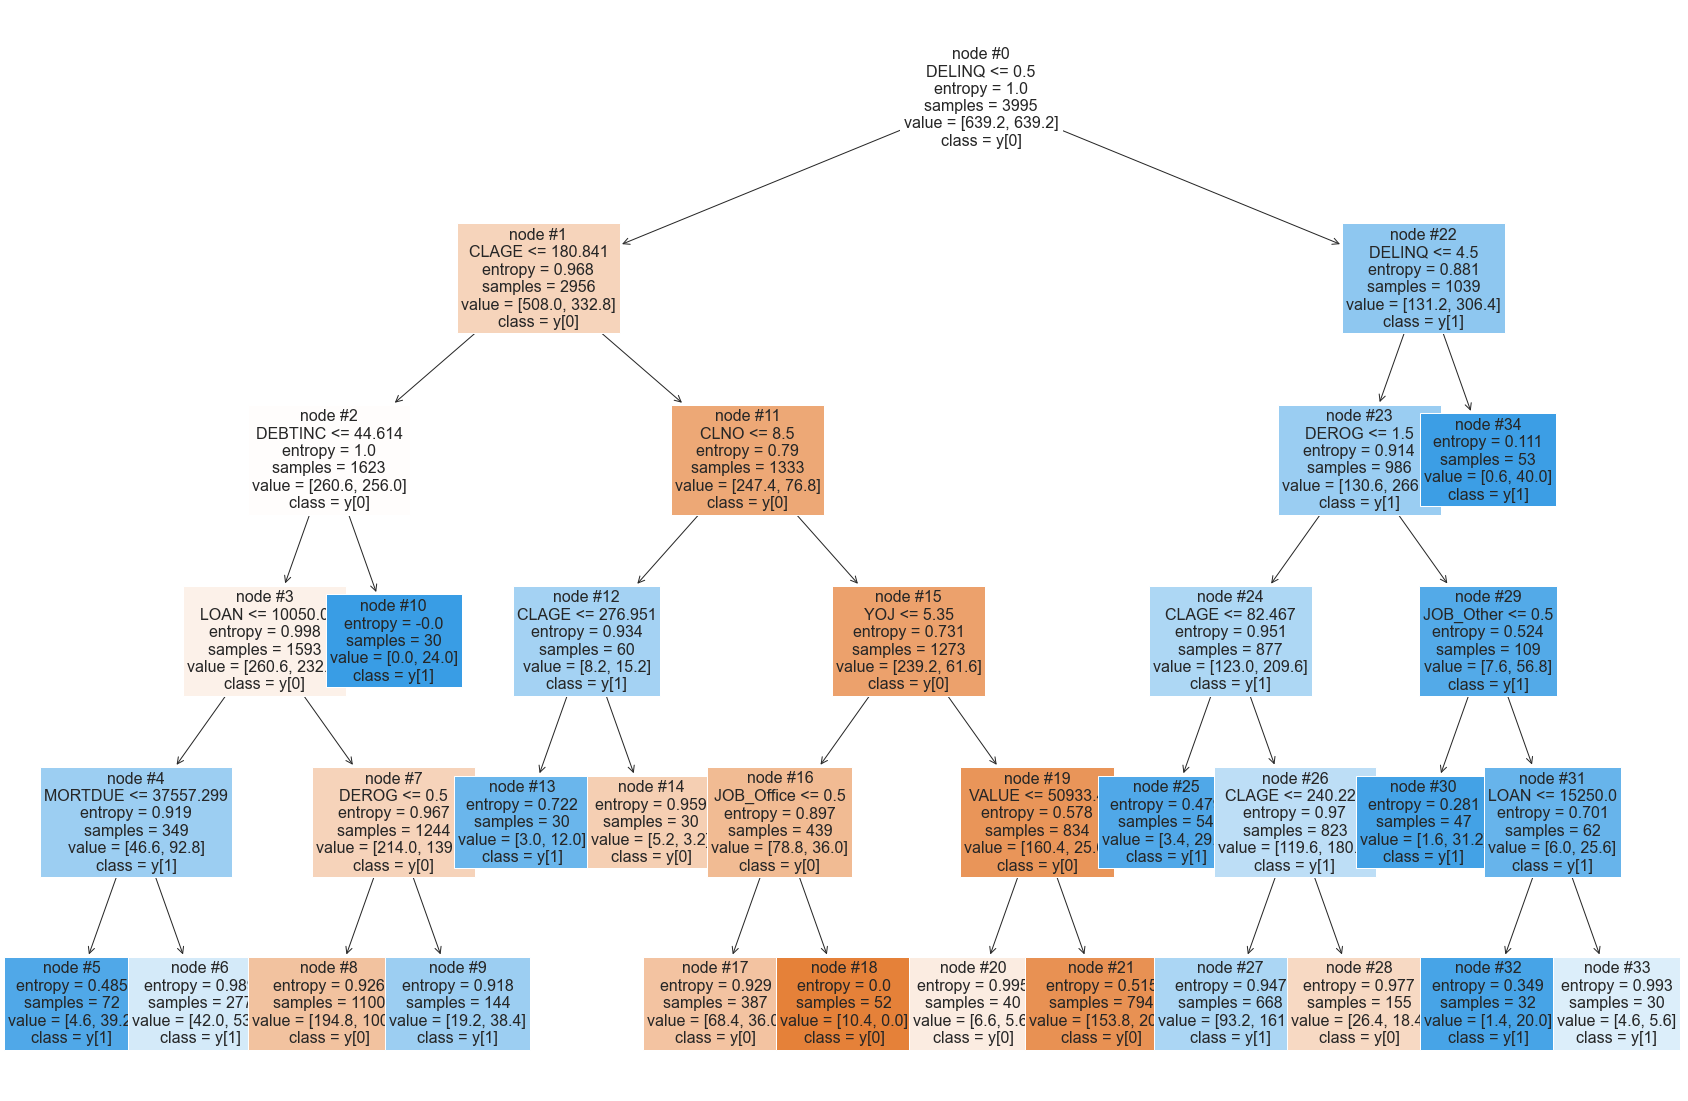

In [219]:
plot_tree(dtree_estimator,X1.columns)

**OBSERVATIONS__**
1. This tree has more nuanced than the first tuned DT, although it is still highly reliant on DTI ratio. 
2. It uses two more features, the number of recent inquiries and job type in replacement of mortgage due. It shows that borrowers with delinquent credit lines > 1 but are professionals or executives can still have good loans. It will be good to see the outcomes of this loan on this and other data set.
3. It shows that clients that have DT < 34.2, have good credit record, but have recent inquiries of more than 4 are likely to default.
4. It also shows that clients with DT < 34.3 have good credit record, but are in their jobs for less then 5.5 months are likely to default.

## Try the random forest with RandomSearchCV using previous parameters

In [220]:
%%time
# Choose the type of classifier. 
rf_estimator_tuned = RandomForestClassifier(class_weight = {0: 0.2, 1: 0.8}, random_state = 1)

# Grid of parameters to choose from
params_rf = {"n_estimators": [100, 150, 200],
    "min_samples_leaf": [15, 20, 30],
    "max_depth": np.arange(5,8),
    "max_features": ['auto', 0.5, 0.7],
             }
            
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the random search
rs_obj = RandomizedSearchCV(rf_estimator_tuned, params_rf, scoring = scorer, cv = 10, n_jobs = 4)

#fit the RandomSearch on train dataset
rs_obj = rs_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator_tuned = rs_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_estimator_tuned.fit(x_train, y_train)

CPU times: user 3.32 s, sys: 122 ms, total: 3.44 s
Wall time: 1min 53s


RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=7,
                       max_features=0.5, min_samples_leaf=30, random_state=1)

In [221]:
# Checking performance on the training and test data
y_pred_train_rf_tuned = rf_estimator_tuned.predict(x_train)
y_pred_test_rf_tuned = rf_estimator_tuned.predict(x_test)

In [222]:
# Compare performance with previous models
show_metrics('Tuned RF without flags',x_train,y_train,x_test,y_test, y_pred_train_rf_tuned, y_pred_test_rf_tuned, rf_estimator_tuned)
comparison_frame.tail()

Model  Train_Accuracy  Test_Accuracy  \
12                        Tuned XGBoost            0.92           0.92   
13           XGBoost with undersampling            0.91           0.88   
14  Tuned XGBoost with scale_pos_weight            0.92           0.90   
15               Tuned DT without flags            0.73           0.73   
16               Tuned RF without flags            0.79           0.77   

    Train_Recall  Test_Recall  Train_Precision  Test_Precision  Train_F1  \
12          0.72         0.68             0.87            0.88      0.79   
13          0.90         0.85             0.93            0.66      0.91   
14          0.90         0.83             0.75            0.72      0.82   
15          0.71         0.70             0.40            0.39      0.51   
16          0.79         0.76             0.48            0.45      0.60   

    Test_F1                              Model with parameters  
12     0.76  XGBClassifier(base_score=0.5, booster='gbtree'...  
13     0.74  XGBClassifier(base_score=0.5, booster='gbtree'...  
14     0.77  XGBClassifier(base_score=0.5, booster='gbtree'...  
15     0.50  DecisionTreeClassifier(class_weight={0: 0.2, 1...  
16     0.57  RandomForestClassifier(class_weight={0: 0.2, 1...

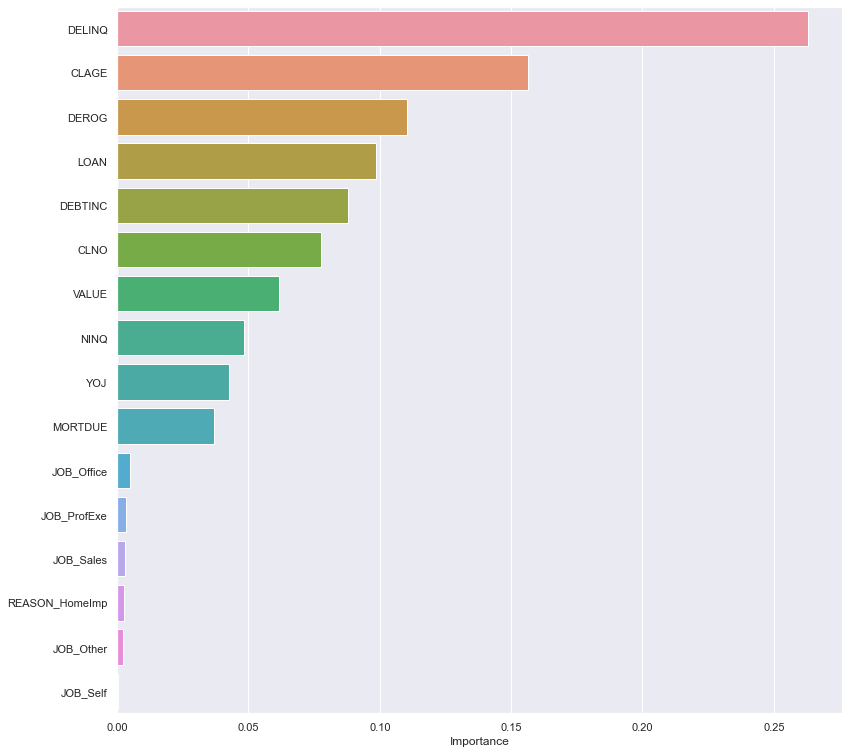

In [223]:
display_imp_features(rf_estimator_tuned.feature_importances_, X1.columns)

## Try Tuned XGBoost using previous parameters

In [224]:
%%time

# Choose the type of classifier. 
classifier = XGBClassifier(random_state = 1, eval_metric = 'logloss')

# Grid of parameters to choose from
params_rf = {"n_estimators": [40, 60, 80],
    "max_depth": np.arange(3,4,5),
    "learning_rate": [0.2, 0.3], # default 0.1 
    "subsample": [0.4, 0.6, 0.8],
    "min_child_weight":[0,1,2,3,4,5],
    "gamma":[0.4, 0.6, 0.8, 0.9, 1],
    "scale_pos_weight":scale_pos
             }
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the random search
rs_obj = RandomizedSearchCV(classifier, params_rf, scoring = scorer, cv = 10, n_jobs = 1, verbose=1)

#fit the RandomSearch on train dataset
rs_obj = rs_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = rs_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
CPU times: user 1min 23s, sys: 4.42 s, total: 1min 28s
Wall time: 57 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=40, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=1, ...)

In [225]:
# Check performance on train and test data
pred_train = xgb_tuned.predict(x_train)
pred_test = xgb_tuned.predict(x_test)

In [226]:
#Compare all results
show_metrics('Tuned XGBoost without flags',x_train,y_train,x_test,y_test, pred_train, pred_test, xgb_tuned)
comparison_frame

Model  Train_Accuracy  Test_Accuracy  \
0                 Logistical Regression            0.86           0.85   
1               LG at optimal threshold            0.89           0.88   
2                         Decision Tree            1.00           0.87   
3                              Tuned DT            0.85           0.83   
4                         Random forest            1.00           0.91   
5                 RF with class weights            1.00           0.91   
6                   Tuned Random Forest            0.87           0.87   
7          RF Tuned with RandomSearchCV            0.87           0.87   
8                              adaboost            0.91           0.90   
9                        Gradient Boost            0.92           0.92   
10                              XGBoost            1.00           0.93   
11          XGBoost with early stopping            0.99           0.93   
12                        Tuned XGBoost            0.92           0.92   
13           XGBoost with undersampling            0.91           0.88   
14  Tuned XGBoost with scale_pos_weight            0.92           0.90   
15               Tuned DT without flags            0.73           0.73   
16               Tuned RF without flags            0.79           0.77   
17          Tuned XGBoost without flags            0.84           0.82   

    Train_Recall  Test_Recall  Train_Precision  Test_Precision  Train_F1  \
0           0.82         0.77             0.61            0.60      0.70   
1           0.71         0.66             0.72            0.70      0.71   
2           1.00         0.64             1.00            0.67      1.00   
3           0.82         0.78             0.59            0.55      0.69   
4           1.00         0.73             1.00            0.82      1.00   
5           1.00         0.68             1.00            0.86      1.00   
6           0.81         0.78             0.65            0.65      0.72   
7           0.81         0.78             0.64            0.64      0.72   
8           0.69         0.65             0.83            0.81      0.75   
9           0.72         0.69             0.88            0.87      0.79   
10          1.00         0.75             1.00            0.89      1.00   
11          0.96         0.74             1.00            0.89      0.98   
12          0.72         0.68             0.87            0.88      0.79   
13          0.90         0.85             0.93            0.66      0.91   
14          0.90         0.83             0.75            0.72      0.82   
15          0.71         0.70             0.40            0.39      0.51   
16          0.79         0.76             0.48            0.45      0.60   
17          0.81         0.76             0.58            0.53      0.67   

    Test_F1                              Model with parameters  
0      0.67  LogisticRegression(class_weight={0: 0.2, 1: 0.8})  
1      0.68  LogisticRegression(class_weight={0: 0.2, 1: 0.8})  
2      0.66  DecisionTreeClassifier(class_weight={0: 0.2, 1...  
3      0.65  DecisionTreeClassifier(class_weight={0: 0.2, 1...  
4      0.77             RandomForestClassifier(random_state=1)  
5      0.76  RandomForestClassifier(class_weight={0: 0.2, 1...  
6      0.71  RandomForestClassifier(class_weight={0: 0.2, 1...  
7      0.70  RandomForestClassifier(class_weight={0: 0.2, 1...  
8      0.72                 AdaBoostClassifier(random_state=1)  
9      0.77         GradientBoostingClassifier(random_state=1)  
10     0.81  XGBClassifier(base_score=0.5, booster='gbtree'...  
11     0.81  XGBClassifier(base_score=0.5, booster='gbtree'...  
12     0.76  XGBClassifier(base_score=0.5, booster='gbtree'...  
13     0.74  XGBClassifier(base_score=0.5, booster='gbtree'...  
14     0.77  XGBClassifier(base_score=0.5, booster='gbtree'...  
15     0.50  DecisionTreeClassifier(class_weight={0: 0.2, 1...  
16     0.57  RandomForestClassifier(class_weight={0: 0.2, 1...  
17     0.62 

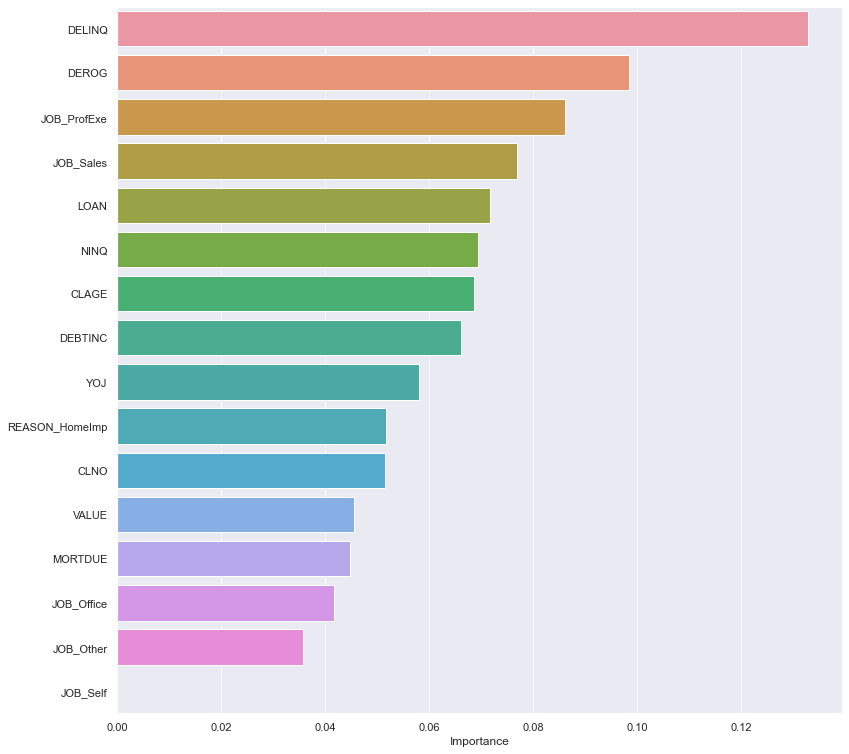

In [227]:
#Display important features
display_imp_features(xgb_tuned.feature_importances_, X1.columns)

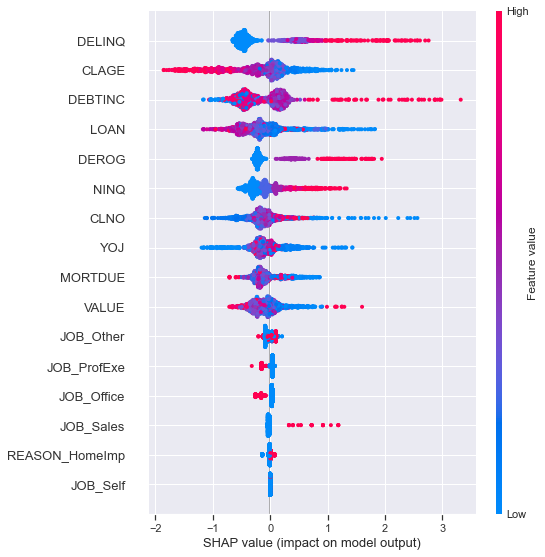

In [228]:
#Display important features using SHAP
explainer = shap.TreeExplainer(xgb_tuned)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values,x_test)

In [229]:
#Save the comparison metrics for reporting
comparison_frame.to_csv('PDS_comparison_metrics.csv')

**Insights: ________**

See the final report and presentation for key insights and recommendations. Below is a gist from this notebook.

1. The best model is a tuned XGBoost model with the best marks in recall, precision, and overall accuracy. 
2. This is the recommended model because it is generalized, has the best performance, explainable, and is based on an algorithm that is widely used, scalable, and flexible.
3. Missing values play an important role in default prediction. It is worth exploring the cost of obtaining key important features.
4. More modeling was tried assuming that key data were not imputed, these did not result in favorable results. Developing the model without the missing value flags will need different training data.
5. It was difficult to tune XGBoost but with the right parameters and trying different techniques, it was tuned to be generalized and to achieve good performance metrics.
6. KNNImputer and treating the missing values before the outliers improved performance of most algorithms.
